### This notebook track and analyze the COVID-19 vaccination progress v.s. public tweets
# Content
### <a href = '#1'>1. Data overview</a>
>#### <a href = '#1.1'>1.1. Tweet data overview</a>
### <a href = '#2'>2. Data preprocessing</a>
>#### <a href = '#2.1'>2.1. Assign country to each tweet</a>
>#### <a href = '#2.2'>2.2. Clean tweet text </a>
### <a href = '#3'>3. NLP on tweet text</a>
>#### <a href = '#3.1'>3.1. Evaluate tweet sentiment</a>
>#### <a href = '#3.2'>3.2. Topic model</a>
### <a href = '#4'>4. Track tweets about COVID vaccination</a>
>#### <a href = '#4.1'>4.1. Track tweet sentiments</a>
>#### <a href = '#4.2'>4.2. Track tweet dominant topics</a>
### <a href = '#5'>5. Linkage between vaccination progress and public tweets</a>
>#### <a href = '#5.1'>5.1. Vaccination v.s. COVID cases v.s. tweet sentiments</a>
>#### <a href = '#5.2'>5.2. Vaccination v.s. COVID cases v.s. tweet topics</a>

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from collections import *

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

import sys, os, collections, nltk, re, time, warnings, ast

from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from geopy.geocoders import Nominatim

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# <a id = '1'>1. Data overview</a>
## <a id = '1.1'>1.1. Tweet data overview</a>

In [2]:
data = pd.read_csv('data/vaccination_all_tweets.csv', parse_dates = ['date'])
data.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                 date                                               text  \
0 2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1 2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2 2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3 2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4 2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

# <a id = '2'>2. Data preprocessing</a>
## <a id = '2.1'>2.1. Assign country to each tweet</a>

In [3]:
## Using geopy, get and assign country to each twitter based on 'user_location'
geolocator = Nominatim(user_agent="My geolocator")
countries = []
for idx in data.index:
    address = data.loc[idx, 'user_location']
    try:
        countries.append(geolocator.geocode(address, addressdetails=True, language = 'en').raw['address']['country'])
    except:
        countries.append(None)
data['country'] = countries
# # fix some data in 'country' column
# country_fix = {
#     'Italia': 'Italy', '中国': 'China', '日本': 'Japan', 'México': 'Mexico',
#     'Brasil': 'Brazil', 'Россия': 'Russia', 'Deutschland': 'Germany',
#     'বাংলাদেশ': 'Bangladesh', 'Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب': 'Morocco'
# }
# data['country'] = data['country'].replace(country_fix)

In [4]:
data.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                 date                                               text  \
0 2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1 2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2 2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3 2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4 2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet        country  
0         0          0       False  United States  
1         1          1       False  United States  
2         0          0       False          Spain  
3       446       2129       False         Canada  
4         0          0       False    Afghanistan

## <a id = '2.2'>2.2. Clean tweet text</a>

In [5]:
## define function to remove links from tweet
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

## define function to remove retweet and @user information
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords and not '…' in word] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [6]:
data['clean_text'] = data.text.apply(clean_tweet)

# <a id = '3'>3. NLP on tweet text</a>
## <a id = '3.1'>3.1. Evaluate tweet sentiment</a>

In [7]:
# Using SentimentIntensityAnalyzer from nltk to get coumpound sentiment for each tweet
def getCompound(texts):
    sia = SentimentIntensityAnalyzer()
    ret = []
    for text in texts:
        ret.append(sia.polarity_scores(text)["compound"])
    return ret

# get tweet sentiment value:
# positive when compound sentiment > 0.05 
# negative for compound sentiment < -0.05
# neutral otherwise
def getSentiment(compoundSentiments):
    ret = []
    for cs in compoundSentiments:
        if cs > 0.05: ret.append('positive')
        elif cs < -0.05: ret.append('negative')
        else: ret.append('neutral')
    return ret;

In [8]:
data['compound_sentiment'] = getCompound(data['clean_text'])
data['sentiment'] = getSentiment(data['compound_sentiment'])

## <a id = '3.2'>3.2. Topic model</a>

In [9]:
# use CountVectorizer to transform text to vector form
vectorizer = CountVectorizer(max_df = 0.9, min_df = 100, token_pattern='\w+|\$[\d\.]+|\S+')
tf = vectorizer.fit_transform(data.drop_duplicates(subset = ['clean_text'])['clean_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [10]:
# st = time.time()
## build topic model using LatentDirichletAllocation estimator from sklearn
search_params = {'n_components': [10, 20, 30], 'learning_decay': [0.5, 0.7, 0.9]}
model = GridSearchCV(LatentDirichletAllocation(), param_grid = search_params)
model.fit(tf)
dump(model, 'GridSearchCVModel.joblib') 
best_lda_model = model.best_estimator_
# ed = time.time()
# print('Model training time:', (ed - st) / 60)

In [11]:
# for each tweet, predict its topic using the obtained vectorizer and topic model
values = best_lda_model.transform(vectorizer.transform(data['clean_text']).toarray())

# add above predicted topic information to tweet data
n = values.shape[0]
n_components = model.best_params_['n_components']
topics = []
for x in range(n_components):
    col = 'Topic' + str(x)
    topics.append(col)
    data[col] = [values[r, x] for r in range(n)]

In [12]:
# Get dominant topic for each tweet
dominant_topic = np.argmax(data[topics].values, axis=1)
data['dominant_topic'] = dominant_topic

In [13]:
# Show top n keywords for each topic
def show_topics(n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in best_lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = topics
df_topic_keywords

Word 0    Word 1     Word 2           Word 3    Word 4    Word 5  \
Topic0  #sputnikv    vaccin         us             want   russian      time   
Topic1        amp    vaccin        get            peopl        ’t    minist   
Topic2   #covaxin    vaccin      india               pm  efficaci      take   
Topic3   #moderna    effect          ’             shot    vaccin      side   
Topic4     vaccin  #sinovac        use       #sinopharm    #covid     china   
Topic5        day       got   #moderna             feel    vaccin     today   
Topic6     vaccin    pfizer      covid              new   moderna  #moderna   
Topic7     #covid  #vaccine   #moderna  #pfizerbiontech    vaccin   #pfizer   
Topic8       dose    vaccin      first  #pfizerbiontech    receiv     thank   
Topic9     vaccin      dose  #sputnikv          million   countri     covid   

               Word 6        Word 7              Word 8         Word 9  \
Topic0          would            eu  #oxfordastrazeneca            say   
Topic1              i           see                take          prime   
Topic2          phase       covaxin               trial         bharat   
Topic3        #pfizer            it                last  #covidvaccine   
Topic4         approv        #china              health          arriv   
Topic5            arm          dose                shot          first   
Topic6           year          week               studi           case   
Topic7   #coronavirus  #astrazeneca           #vaccines           news   
Topic8  #covidvaccine         today                 one       #moderna   
Topic9         russia         first                   v        sputnik   

              Word 10      Word 11 Word 12         Word 13             Word 14  
Topic0            die  astrazeneca  oxford         #russia                 #eu  
Topic1             ’m         need    like            mani                 don  
Topic2        biotech         took    ocgn            modi              clinic  
Topic3       #vaccine  #vaccinated  second             got                 far  
Topic4          covid       chines   emerg        #vaccine                said  
Topic5           hour    yesterday    sore          second                  nd  
Topic6       biontech         dose     old            part              #covid  
Topic7  #covidvaccine        death    test  #pfizervaccine        #vaccination  
Topic8            got        covid     get          #covid  #oxfordastrazeneca  
Topic9         receiv       suppli  #covid      coronaviru               start

In [14]:
# save the processed data with sentiment and topic information
data.to_csv('data/vaccination_tweets_with_nlp.csv', index = False)
# data = pd.read_csv('data/vaccination_tweets_with_nlp.csv', parse_dates = ['date'])
data.head()

id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel                        NaN   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   
3  Hosting "CharlesAdlerTonight" Global News Radi...  2008-09-10 11:28:53   
4  Citizen News Channel bringing you an alternati...  2020-04-23 17:58:42   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   
3           49165          3933            21853           True   
4             152           580             1473          False   

                 date                                               text  \
0 2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1 2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2 2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3 2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4 2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet        country  \
0         0          0       False  United States   
1         1          1       False  United States   
2         0          0       False          Spain   
3       446       2129       False         Canada   
4         0          0       False    Afghanistan   

                                          clean_text  compound_sentiment  \
0  folk said daikon past could treat cytokin stor...              0.4019   
1  world wrong side histori year hope biggest vac...             -0.0516   
2  #coronavirus #sputnikv #astrazeneca #pfizerbio...              0.0000   
3  fact immut senat even ethic sturdi enough ackn...              0.0000   
4     explain need vaccin #whereareallthesickpeople               0.0000   

  sentiment    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5  \
0  positive  0.261665  0.025004  0.025001  0.025000  0.272154  0.025001   
1  negative  0.432491  0.016669  0.016670  0.240037  0.016670  0.016671   
2   neutral  0.265889  0.010001  0.010000  0.163091  0.010001  0.010001   
3   neutral  0.033336  0.699990  0.033334  0.033333  0.033334  0.033335   
4   neutral  0.033342  0.699939  0.033337  0.033338  0.033344  0.033337   

     Topic6    Topic7    Topic8    Topic9  dominant_topic  
0  0.025007  0.291157  0.025009  0.025002               7  
1  0.210780  0.016670  0.016669  0.016672               0  
2  0.010001  0.501013  0.010001  0.010002               7  
3  0.033335  0.033334  0.033334  0.033335               1  
4  0.033342  0.033338  0.033340  0.033342               1

# <a id = '4'>4. Track tweets about COVID vaccination</a>

In [15]:
# hs = set()
# for idx in data[data['hashtags'].notna()].index:
#     has = data.loc[idx, 'hashtags']
#     has = ast.literal_eval(has)
#     for h in has:
#         hs.add(h)

## <a id = '4.1'>4.1. Track tweet sentiments</a>

In [16]:
# add 'number of tweets' column which add up tweet, retweet and favoriates
data['number of tweets'] = 1 + data['retweets'] + data['favorites']

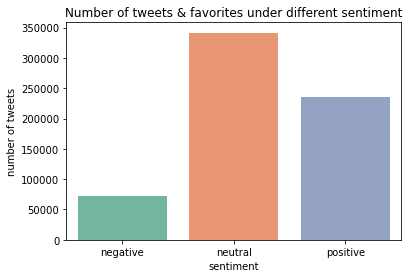

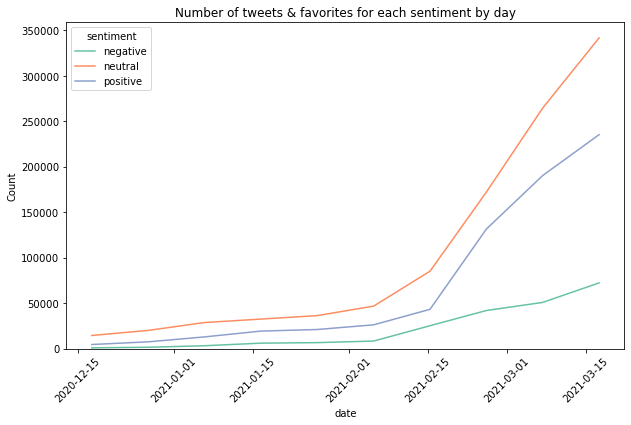

In [17]:
## define function to plot data by day
def plotByDay(data, hue, weights):
    fig = plt.figure(figsize = (10, 6))
    ax = sb.histplot(data = data, x = 'date', hue = hue, palette = "Set2",
                     weights = weights, element = 'poly', fill = False, cumulative=True)
    ax.set_title('Number of tweets & favorites for each ' + hue + ' by day')
    for xticker in ax.get_xticklabels():
        xticker.set_rotation(45)
    plt.show()

# show number of tweets under different sentiments
dataBySentiment = data[['number of tweets', 'sentiment']].groupby(by = 'sentiment').agg('sum').reset_index()
fig = plt.figure()
ax = sb.barplot(data = dataBySentiment, x = 'sentiment', y = 'number of tweets', palette = 'Set2')
ax.set_title('Number of tweets & favorites under different sentiment')
plt.show()

## track number of positive, negative and neutral tweets by day
dataSentimentByDay = data[[
    'number of tweets', 'sentiment', 'date']].groupby(by = ['sentiment', 'date']).agg('sum').reset_index()
plotByDay(dataSentimentByDay, 'sentiment', 'number of tweets')

### Thoughts:
* In general, the public is positive about COVID vaccination
* There has been rapid increase for the number of tweets & favoriates after round 02/15/2021. We will further look into this later by combining the vaccination progress data.

## <a id = '4.2'>4.2. Track tweet dominant topics</a>

In [18]:
## topic key words
df_topic_keywords

Word 0    Word 1     Word 2           Word 3    Word 4    Word 5  \
Topic0  #sputnikv    vaccin         us             want   russian      time   
Topic1        amp    vaccin        get            peopl        ’t    minist   
Topic2   #covaxin    vaccin      india               pm  efficaci      take   
Topic3   #moderna    effect          ’             shot    vaccin      side   
Topic4     vaccin  #sinovac        use       #sinopharm    #covid     china   
Topic5        day       got   #moderna             feel    vaccin     today   
Topic6     vaccin    pfizer      covid              new   moderna  #moderna   
Topic7     #covid  #vaccine   #moderna  #pfizerbiontech    vaccin   #pfizer   
Topic8       dose    vaccin      first  #pfizerbiontech    receiv     thank   
Topic9     vaccin      dose  #sputnikv          million   countri     covid   

               Word 6        Word 7              Word 8         Word 9  \
Topic0          would            eu  #oxfordastrazeneca            say   
Topic1              i           see                take          prime   
Topic2          phase       covaxin               trial         bharat   
Topic3        #pfizer            it                last  #covidvaccine   
Topic4         approv        #china              health          arriv   
Topic5            arm          dose                shot          first   
Topic6           year          week               studi           case   
Topic7   #coronavirus  #astrazeneca           #vaccines           news   
Topic8  #covidvaccine         today                 one       #moderna   
Topic9         russia         first                   v        sputnik   

              Word 10      Word 11 Word 12         Word 13             Word 14  
Topic0            die  astrazeneca  oxford         #russia                 #eu  
Topic1             ’m         need    like            mani                 don  
Topic2        biotech         took    ocgn            modi              clinic  
Topic3       #vaccine  #vaccinated  second             got                 far  
Topic4          covid       chines   emerg        #vaccine                said  
Topic5           hour    yesterday    sore          second                  nd  
Topic6       biontech         dose     old            part              #covid  
Topic7  #covidvaccine        death    test  #pfizervaccine        #vaccination  
Topic8            got        covid     get          #covid  #oxfordastrazeneca  
Topic9         receiv       suppli  #covid      coronaviru               start

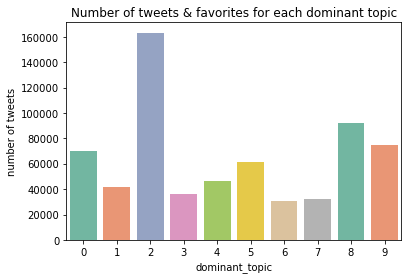

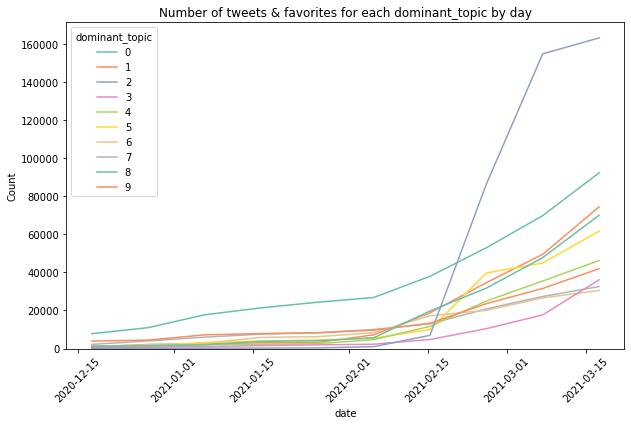

In [19]:
# # Set the default color cycle
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[
#     'red', 'green', 'blue', 'yellow', 'black', 'purple', 'orange', 'grey', 'pink', 'brown'])
# number of tweets in each dominant topic
dataByTopic = data[['number of tweets', 'dominant_topic']].groupby(by = 'dominant_topic').agg('sum').reset_index()
fig = plt.figure()
ax = sb.barplot(data = dataByTopic, x = 'dominant_topic', y = 'number of tweets', palette = "Set2")
ax.set_title('Number of tweets & favorites for each dominant topic')
plt.show()

# number of tweets in each dominant topic by day
dataTopicByDay = data[[
    'number of tweets', 'dominant_topic', 'date']].groupby(by = ['dominant_topic', 'date']).agg('sum').reset_index()
plotByDay(dataTopicByDay, 'dominant_topic', 'number of tweets')

### Tweet sentiment in different dominant topics

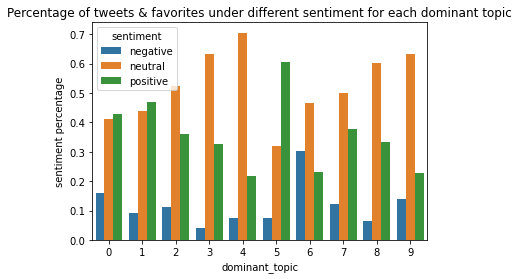

*****Topic0*****


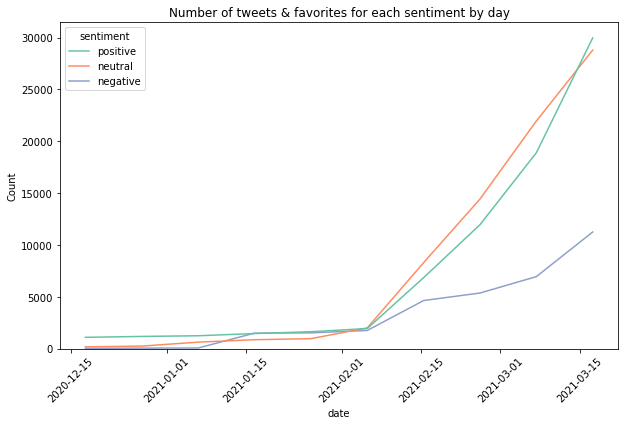

*****Topic1*****


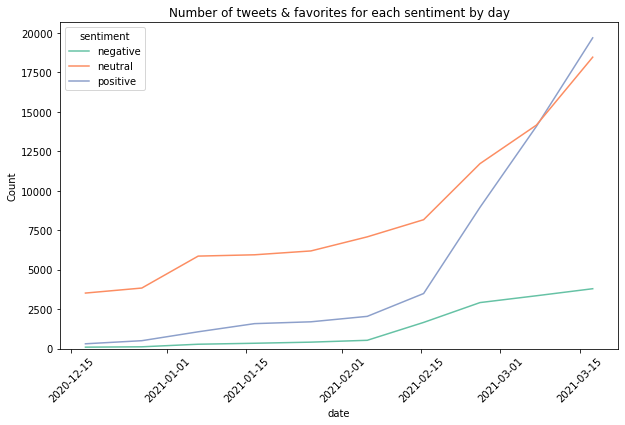

*****Topic2*****


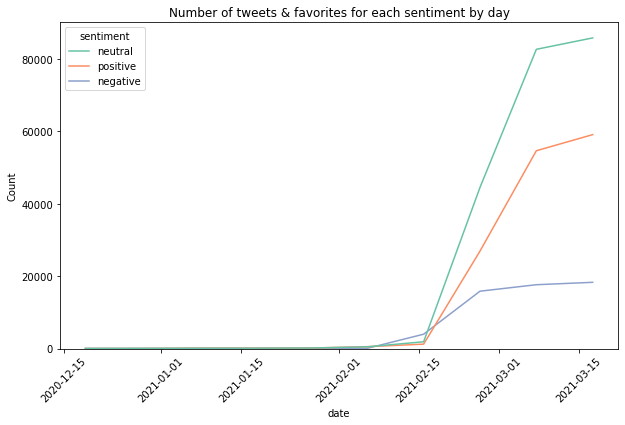

*****Topic3*****


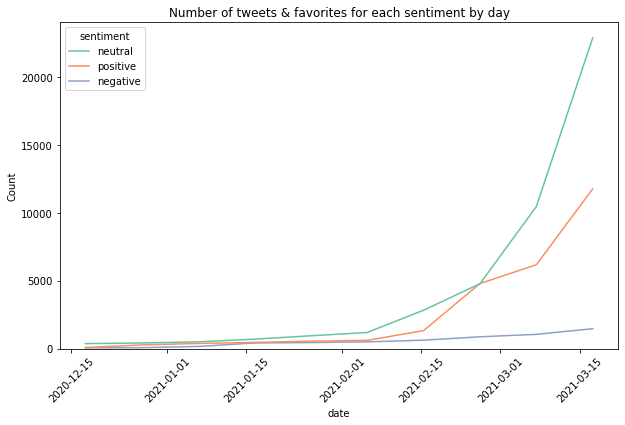

*****Topic4*****


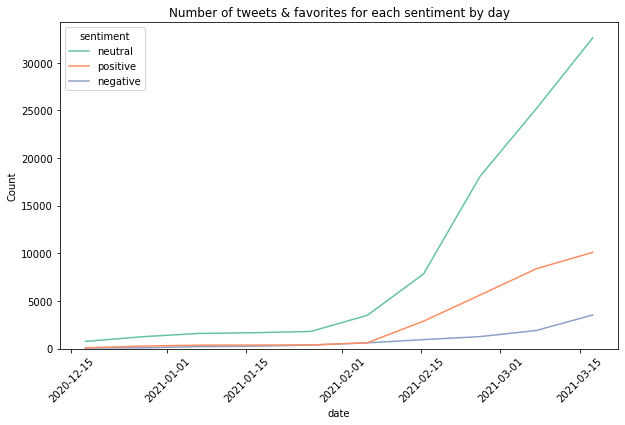

*****Topic5*****


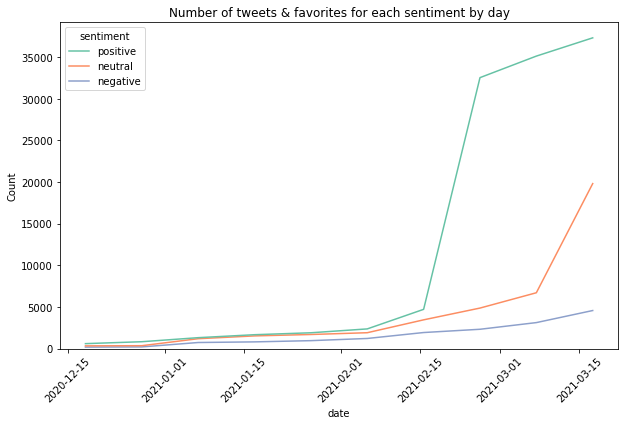

*****Topic6*****


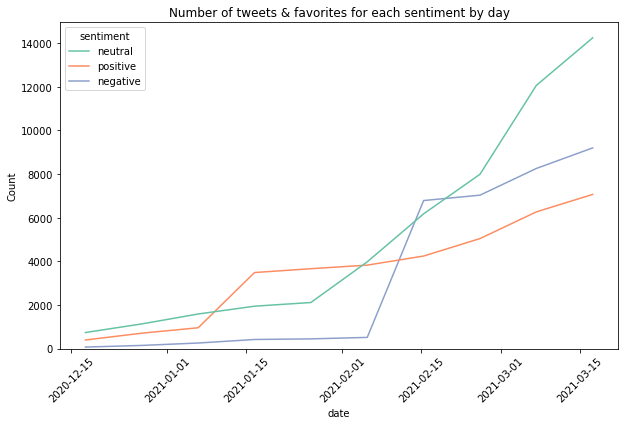

*****Topic7*****


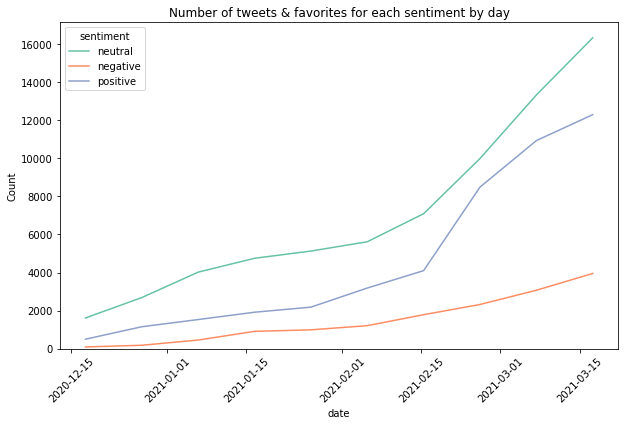

*****Topic8*****


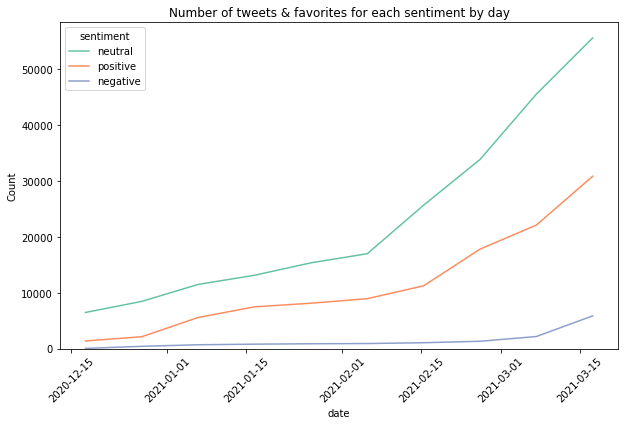

*****Topic9*****


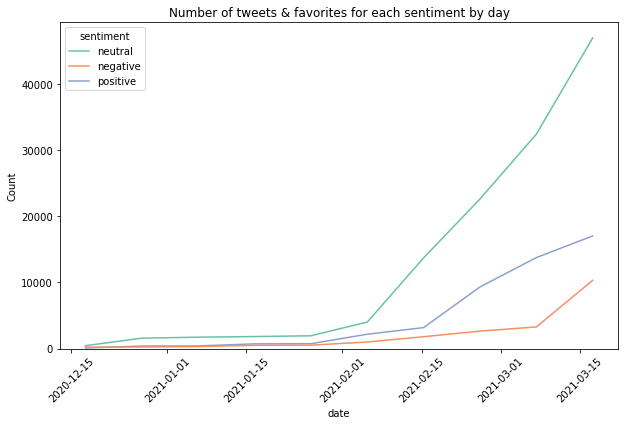

In [20]:
# show tweet sentiments statistics over different dominant_topic
dataByTS = data[['number of tweets', 'sentiment', 'dominant_topic']].groupby(by = [
    'dominant_topic', 'sentiment']).agg('sum').reset_index()

# plot sentiment percentage in each dominant topic
dataByTopicTotal = data[['number of tweets', 'dominant_topic']].groupby(
    by = 'dominant_topic').agg('sum').reset_index().rename(columns = {'number of tweets': 'topic total'})
dataByTS = dataByTS.merge(dataByTopicTotal, on = 'dominant_topic')
dataByTS['sentiment percentage'] = dataByTS['number of tweets'] / dataByTS['topic total']
fig = plt.figure()
ax = sb.barplot(data = dataByTS, x = 'dominant_topic', y = 'sentiment percentage', hue = 'sentiment')
ax.set_title('Percentage of tweets & favorites under different sentiment for each dominant topic')
plt.show()

# show tweet sentiments statistics over different dominant_topic by day
dataTSByDay = data[['number of tweets', 'dominant_topic', 'date', 'sentiment']].groupby(by = 'dominant_topic')
for topic in dataTSByDay.groups:
    data_topic = dataTSByDay.get_group(topic)[[
        'number of tweets', 'date', 'sentiment']].groupby(by = ['date', 'sentiment']).agg('sum').reset_index()
    print('*' * 5 + 'Topic' + str(topic) + '*' * 5)
    plotByDay(data_topic, 'sentiment', 'number of tweets')

### Thoughts:
* In most cases, different topics are primarily focused on different vaccines.
* Topic2, Topic4 and Topic6 have more tweets, retweets and favarites. These topics are more focused on Covaxin and Sputnikv vaccines, which are from India and Russia, respectively.
* Number of tweets & favoriates in all topics starts to increase more rapidly after 02/15/2021, especially Topic6.
* In general, the public is positive about COVID vaccination in different domianant topics.
* Dominant Topic0 have more negative tweets. If we check topic keywords, we can see that Topic 0 involves no specific vaccine, which may be that users who post these tweets are more skeptical of the effectiveness of these vaccines.
* Dominant Topic9 also receives many negative tweets. The major difference between Topic9 and other topics are that it has 'death' keyword, which indicates these tweets maybe more concerned about the news and reports on the side effects of the vaccines.

# <a id = '5'>5. Linkage between vaccination progress and public tweets</a>

In [21]:
dataVaccine = pd.read_csv('data/country_vaccinations_cleaned.csv', parse_dates= ['date'])
dataVaccine.head()

country iso_code       date  total_vaccinations  people_vaccinated  \
0  United Kingdom      GBR 2020-12-13             86465.0            86465.0   
1          Canada      CAN 2020-12-14                 5.0                NaN   
2  United Kingdom      GBR 2020-12-14                 NaN                NaN   
3          Canada      CAN 2020-12-15               723.0                NaN   
4           China      CHN 2020-12-15           1500000.0                NaN   

   people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
0                      NaN                     NaN                 NaN   
1                      NaN                     NaN                 NaN   
2                      NaN                     NaN             84117.0   
3                      NaN                   718.0               718.0   
4                      NaN                     NaN                 NaN   

   total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
0                            0.13                           0.13   
1                            0.00                            NaN   
2                             NaN                            NaN   
3                            0.00                            NaN   
4                            0.10                            NaN   

   people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
0                                  NaN                             NaN   
1                                  NaN                             NaN   
2                                  NaN                          1239.0   
3                                  NaN                            19.0   
4                                  NaN                             NaN   

                                       vaccines  \
0           Oxford/AstraZeneca, Pfizer/BioNTech   
1  Moderna, Oxford/AstraZeneca, Pfizer/BioNTech   
2           Oxford/AstraZeneca, Pfizer/BioNTech   
3  Moderna, Oxford/AstraZeneca, Pfizer/BioNTech   
4   Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac   

                                         source_name  \
0                   Government of the United Kingdom   
1  Official data from provinces via covid19tracke...   
2                   Government of the United Kingdom   
3  Official data from provinces via covid19tracke...   
4                         National Health Commission   

                                      source_website  
0  https://coronavirus.data.gov.uk/details/health...  
1  https://covid19tracker.ca/vaccinationtracker.html  
2  https://coronavirus.data.gov.uk/details/health...  
3  https://covid19tracker.ca/vaccinationtracker.html  
4  https://www.reuters.com/article/us-health-coro...

In [22]:
dataCase = pd.read_csv('data/COVID-19 - Johns Hopkins University_cleaned.csv', parse_dates=['date'])
dataCase.head()

country  Year  daily_cases  daily_deaths  total_cases  total_deaths  \
0          Japan     1          NaN           NaN          2.0           NaN   
1        Vietnam     1          NaN           NaN          NaN           NaN   
2  United States     1          NaN           NaN          1.0           NaN   
3       Thailand     1          NaN           NaN          4.0           NaN   
4      Singapore     1          NaN           NaN          NaN           NaN   

   Daily new confirmed cases of COVID-19 per million people  \
0                                                NaN          
1                                                NaN          
2                                                NaN          
3                                                NaN          
4                                                NaN          

   Daily new confirmed deaths due to COVID-19 per million people  \
0                                                NaN               
1                                                NaN               
2                                                NaN               
3                                                NaN               
4                                                NaN               

   total_cases_permillion  total_deaths_permillion  \
0                   0.016                      NaN   
1                     NaN                      NaN   
2                   0.003                      NaN   
3                   0.057                      NaN   
4                     NaN                      NaN   

   Days since the total confirmed cases of COVID-19 reached 100  \
0                                              -30.0              
1                                              -60.0              
2                                              -42.0              
3                                              -53.0              
4                                              -38.0              

   Days since the total confirmed deaths of COVID-19 reached 5  \
0                                              -37.0             
1                                             -193.0             
2                                              -40.0             
3                                              -65.0             
4                                              -72.0             

   Days since the total confirmed cases of COVID-19 per million people reached 1  \
0                                              -31.0                               
1                                              -60.0                               
2                                              -45.0                               
3                                              -50.0                               
4                                               -6.0                               

   Days since the total confirmed deaths of COVID-19 per million people reached 0.1  \
0                                              -48.0                                  
1                                             -197.0                                  
2                                              -49.0                                  
3                                              -67.0                                  
4                                              -59.0                                  

   Days since 30 daily new confirmed cases recorded  \
0                                             -42.0   
1                                            -190.0   
2                                             -42.0   
3                                             -53.0   
4                                             -56.0   

   Days since 50 daily new confirmed cases recorded  \
0                                             -44.0   
1                                            -190.0   
2                                             -43.0   
3                                   

## <a id = '5.1'>5.1. Vaccination v.s. COVID cases v.s. tweet sentiments</a>

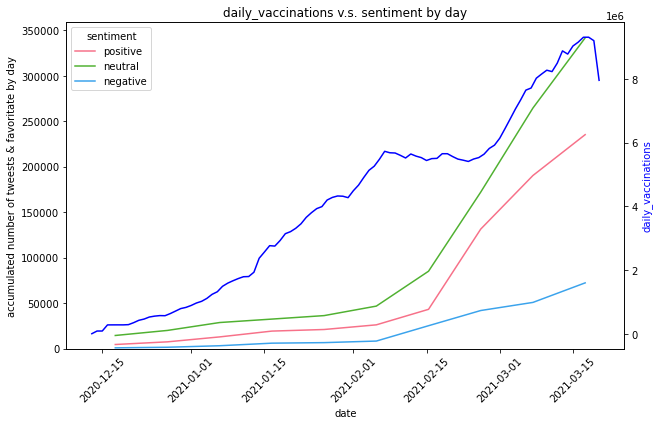

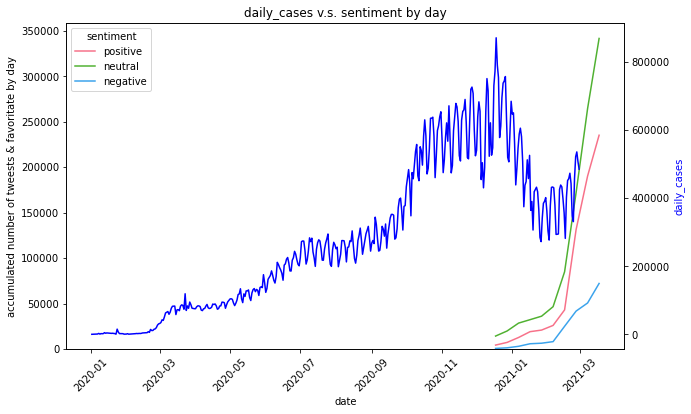

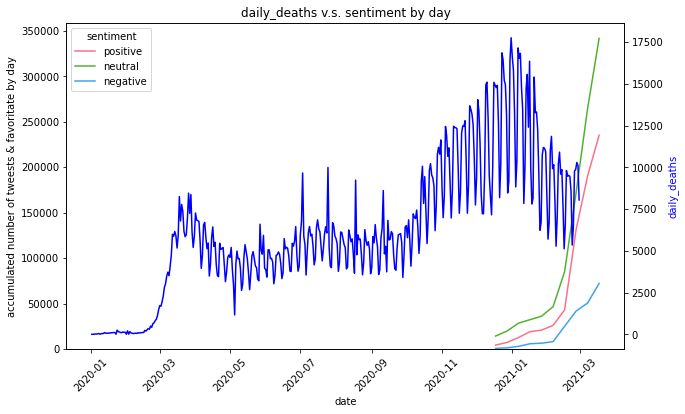

In [40]:
# define function to plot vaccinations/cases/deaths v.s. tweets sentiments/topics
def plotVsTweets(data, col, data_tweet, hue, hueOrder):
    fig, ax1 = plt.subplots(figsize = (10, 6))
    ax2 = ax1.twinx()
    sb.histplot(data = data_tweet, x = 'date', hue = hue, hue_order = hueOrder,
                palette = sb.color_palette("husl", len(hueOrder)), weights = 'number of tweets',
                element = 'poly', fill = False, cumulative=True, ax = ax1)
    ax2.plot(data['date'], data[col], color = 'blue')
    for xticker in ax1.get_xticklabels():
        xticker.set_rotation(45)
    ax1.set_title(col + ' v.s. ' + hue + ' by day')
    ax1.set_xlabel('date')
    ax1.set_ylabel('accumulated number of tweests & favoritate by day')
    ax2.set_ylabel(col, color = 'blue')
    plt.show()

## get daily vaccinations, daily cases and daily deaths data
dataVaccineByDay = dataVaccine[['daily_vaccinations', 'date', 'country']].groupby(
    by = ['date', 'country']).agg('max').reset_index()[[
    'date', 'daily_vaccinations']].groupby(by = 'date').agg('sum').reset_index()
dataCaseByDay = dataCase[['date', 'daily_cases', 'daily_deaths', 'country']].groupby(
    by = ['country', 'date']).agg('max').reset_index()[[
    'date', 'daily_cases', 'daily_deaths']].groupby(by = 'date').agg('sum').reset_index()

hueOrder = ['positive', 'neutral', 'negative']
# plot 'daily_vaccinations' v.s. tweets sentiments by day
plotVsTweets(dataVaccineByDay, 'daily_vaccinations', dataSentimentByDay, 'sentiment', hueOrder)
# plot 'daily_cases' v.s. tweets sentiments by day
plotVsTweets(dataCaseByDay, 'daily_cases', dataSentimentByDay, 'sentiment', hueOrder)
# plot 'daily_deaths' v.s. tweets sentiments by day
plotVsTweets(dataCaseByDay, 'daily_deaths', dataSentimentByDay, 'sentiment', hueOrder)

In [28]:
tmp = dataVaccine[[
    'country', 'total_vaccinations']].groupby(by = 'country').agg(
    'max').sort_values(by = 'total_vaccinations', ascending = False).reset_index().loc[: 19, :]
top20Country = {x for x in tmp['country']}

---------- United Kingdom ----------


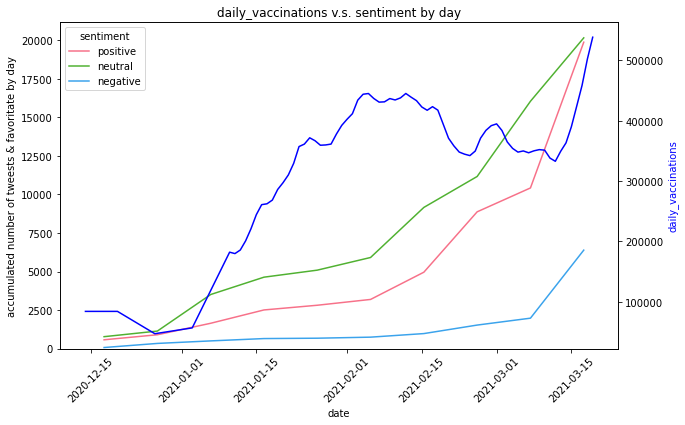

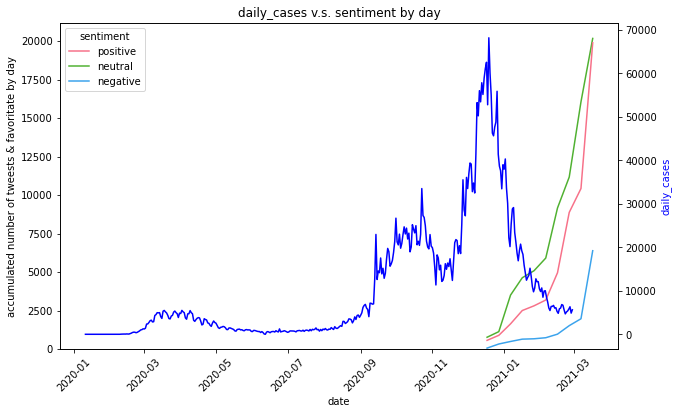

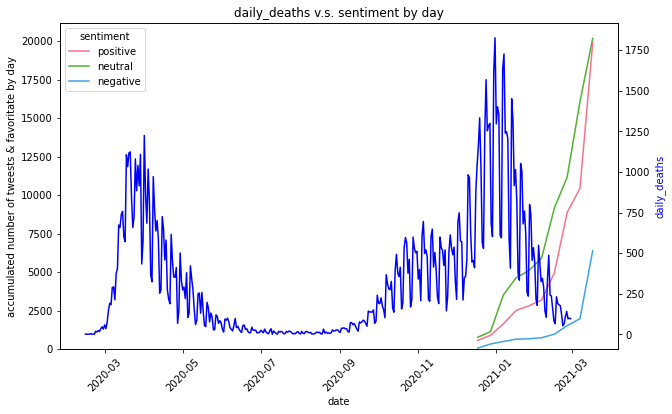

******************************
---------- Morocco ----------


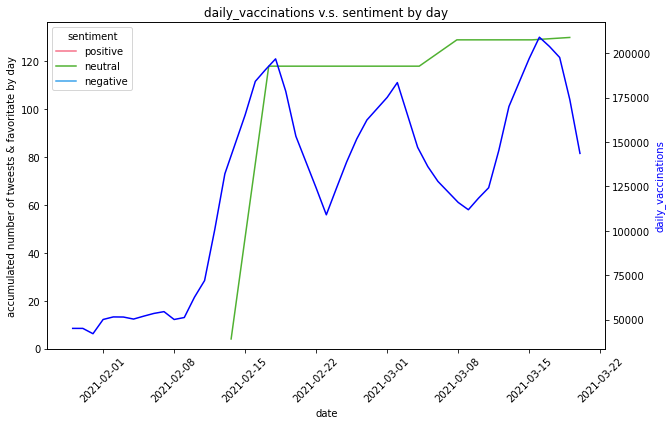

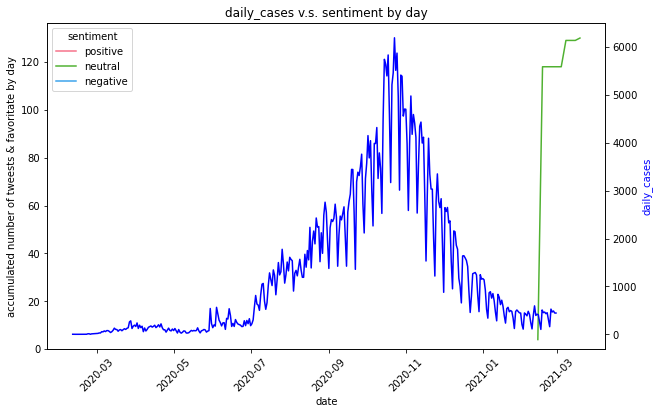

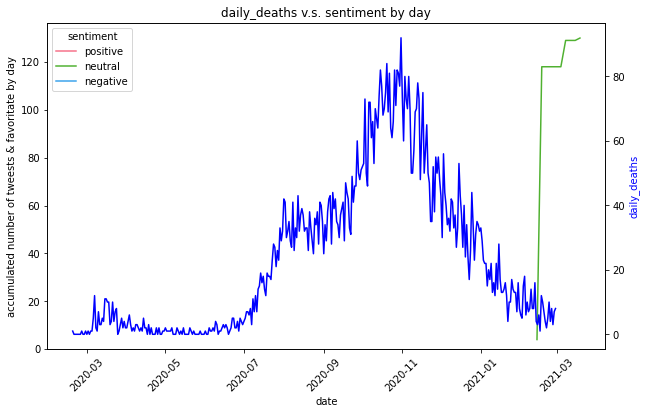

******************************
---------- China ----------


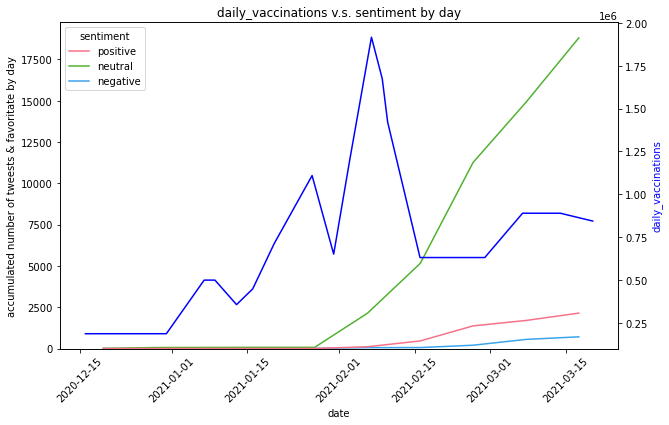

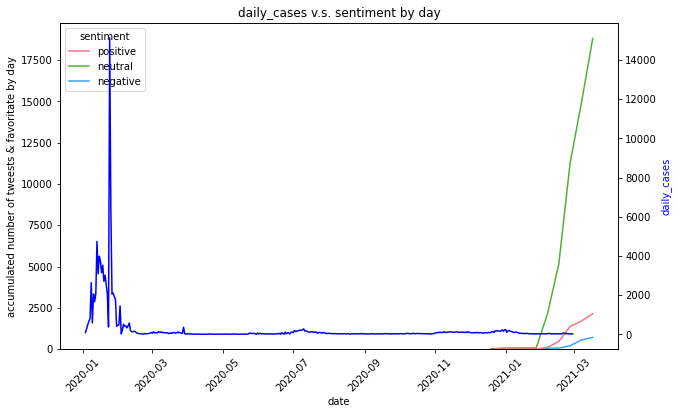

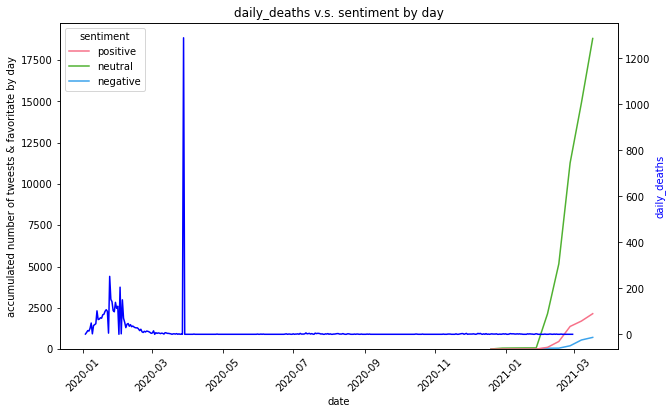

******************************
---------- Germany ----------


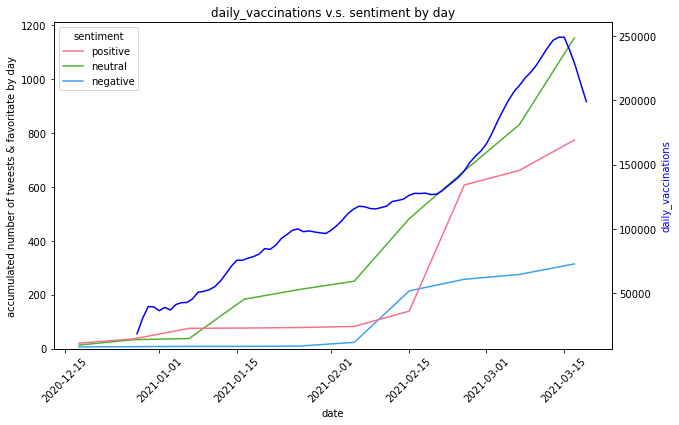

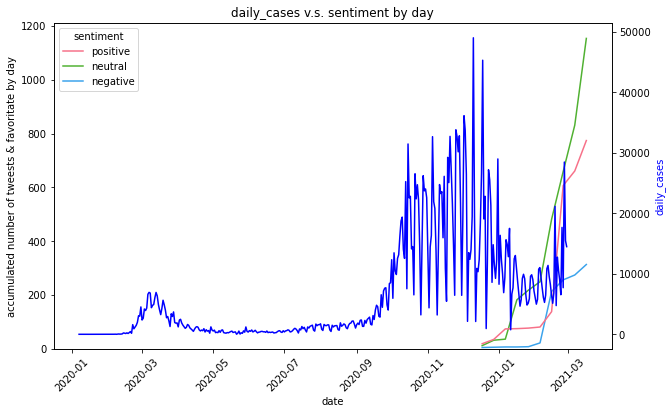

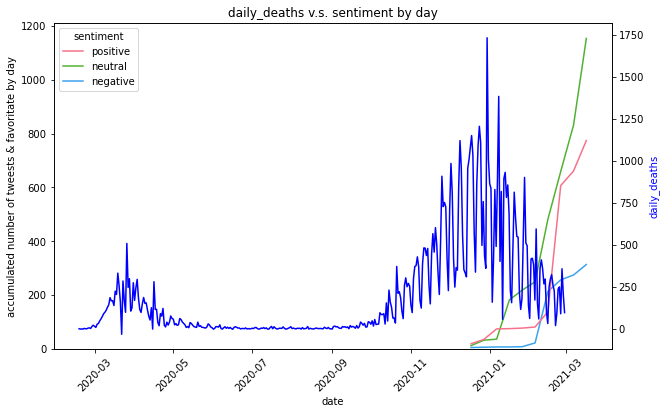

******************************
---------- Indonesia ----------


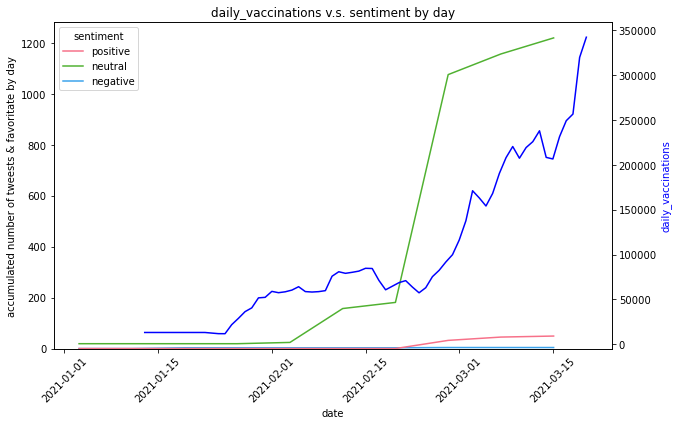

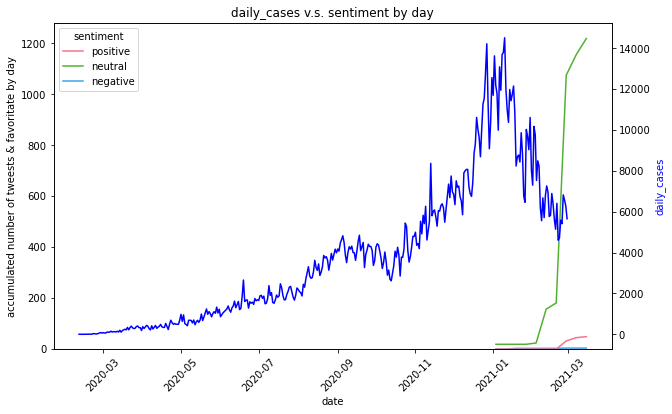

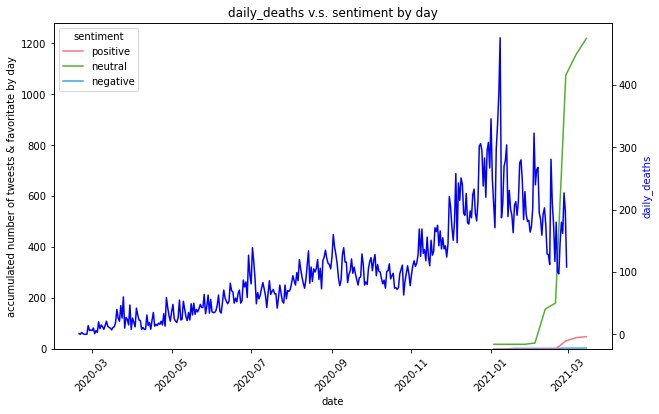

******************************
---------- Canada ----------


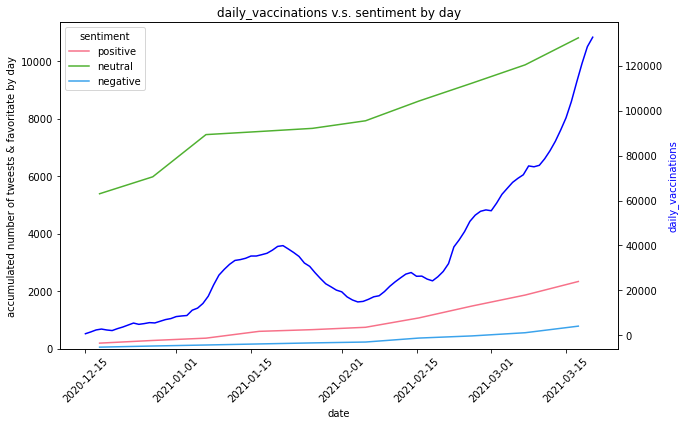

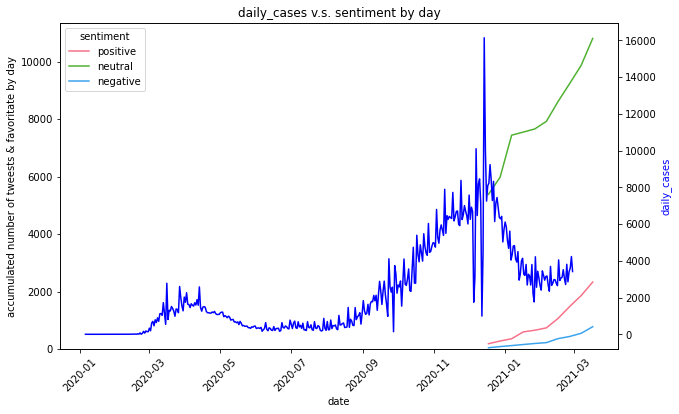

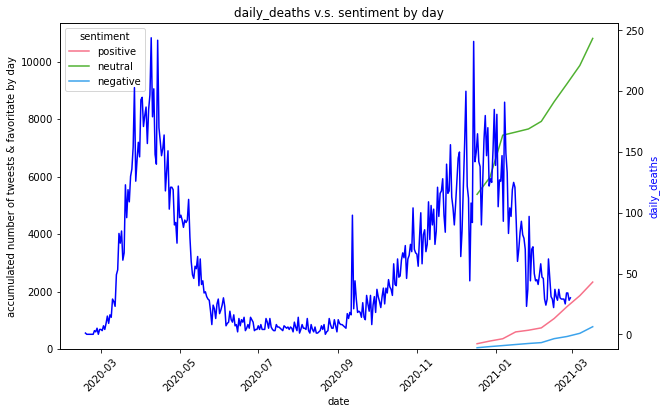

******************************
---------- United States ----------


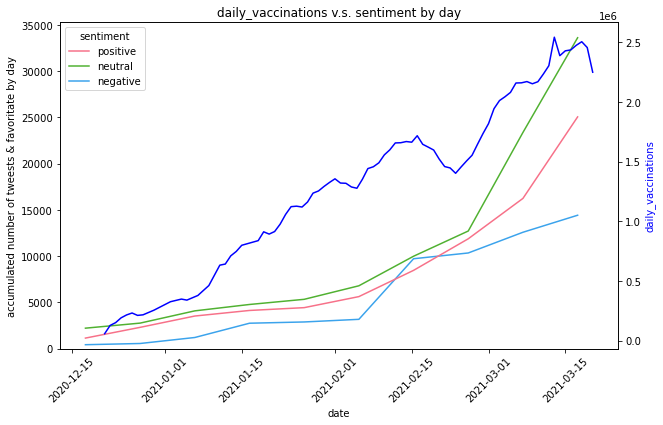

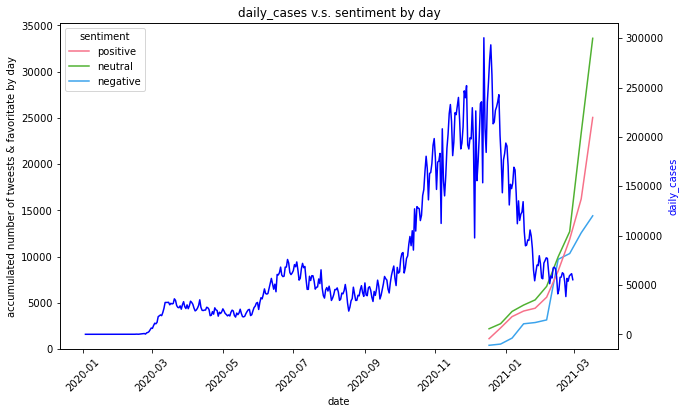

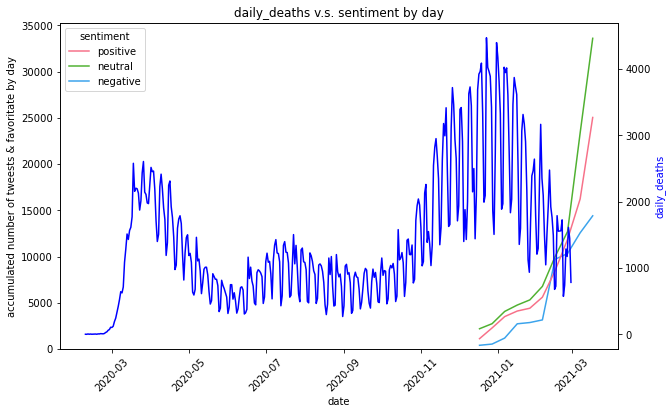

******************************
---------- Mexico ----------


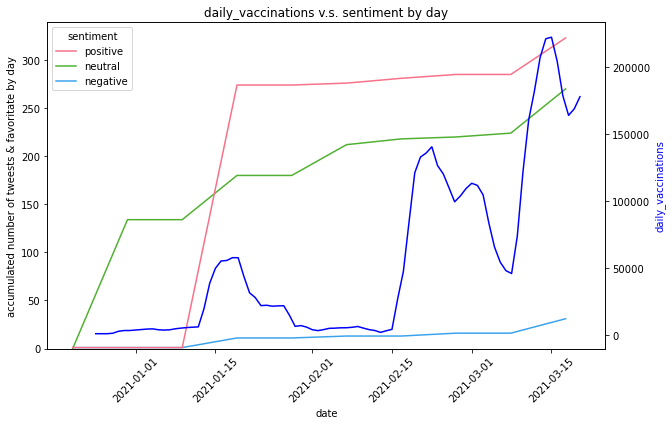

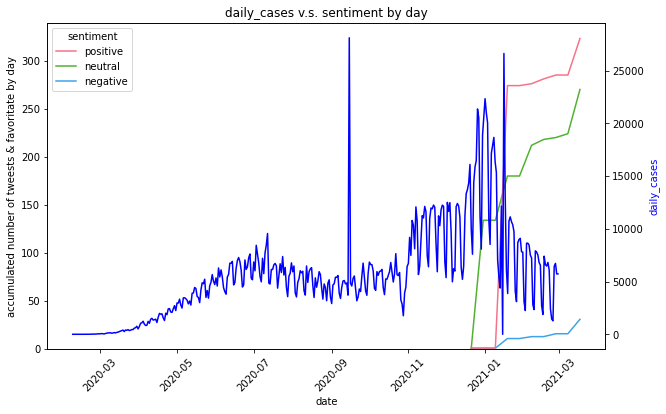

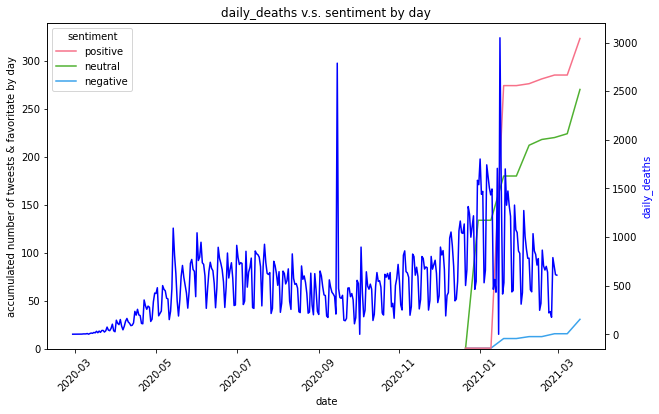

******************************
---------- France ----------


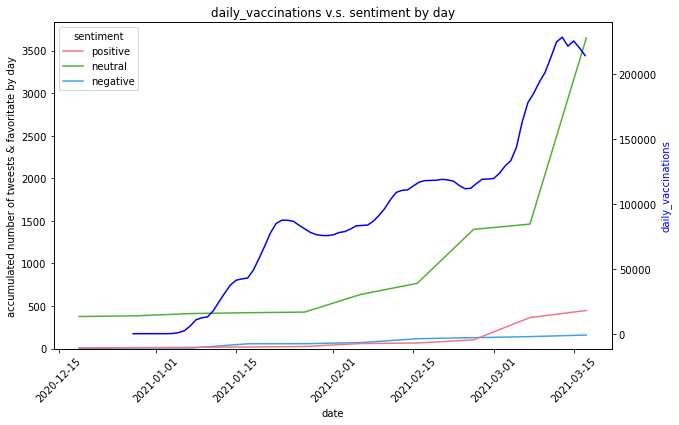

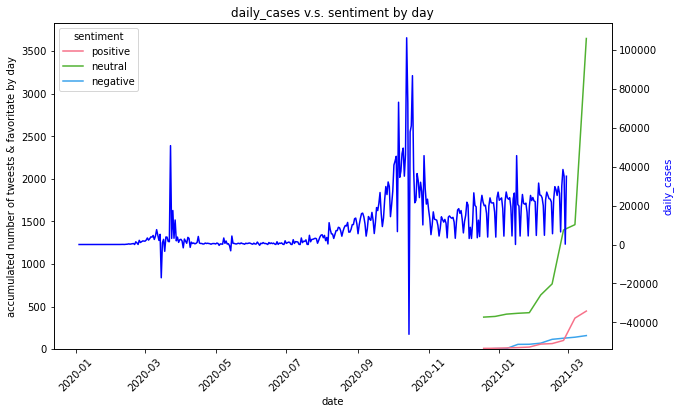

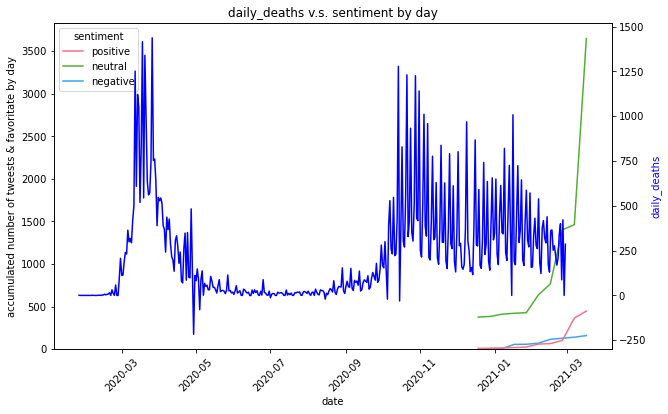

******************************
---------- Israel ----------


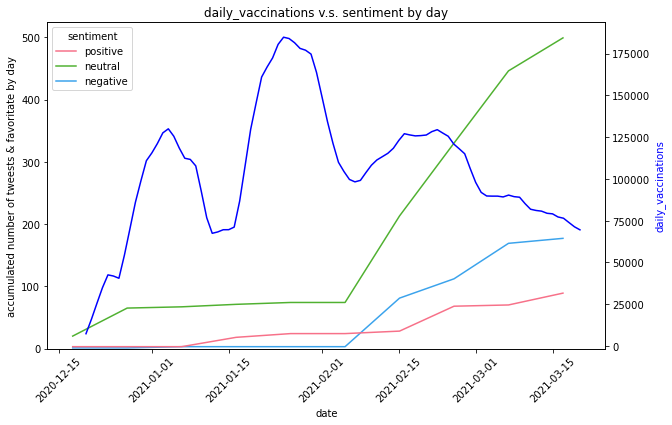

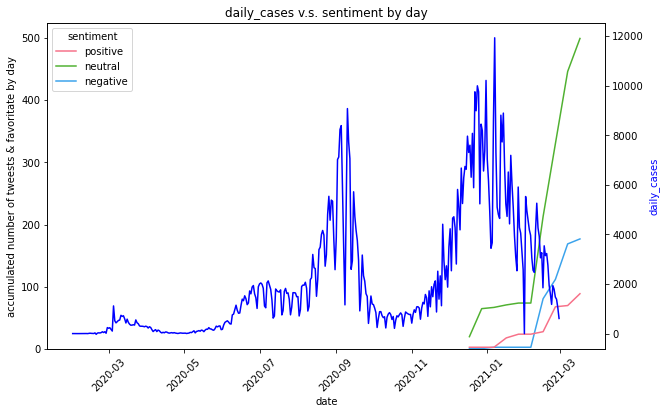

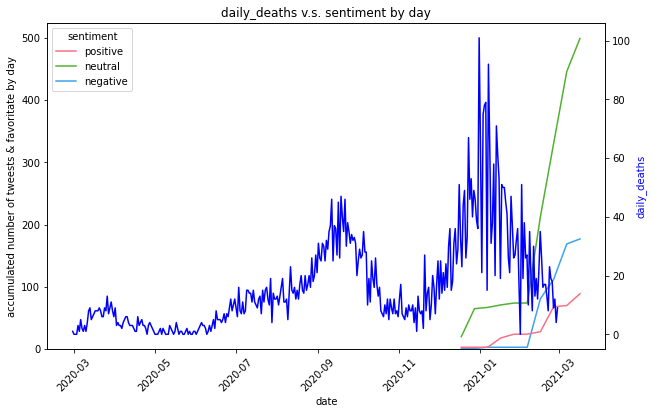

******************************
---------- India ----------


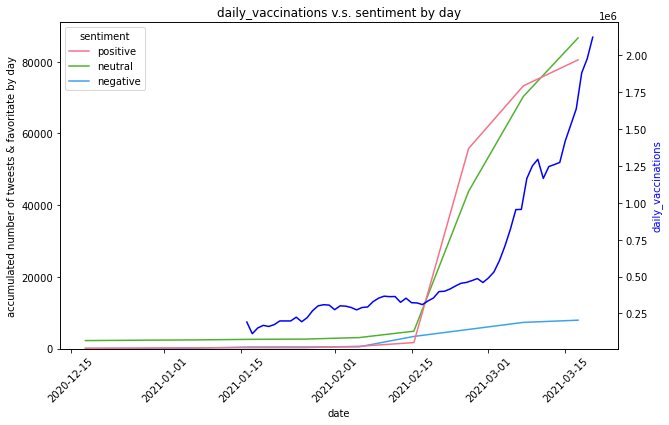

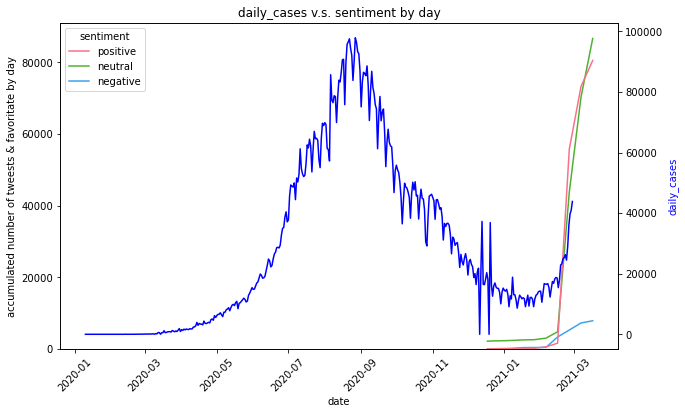

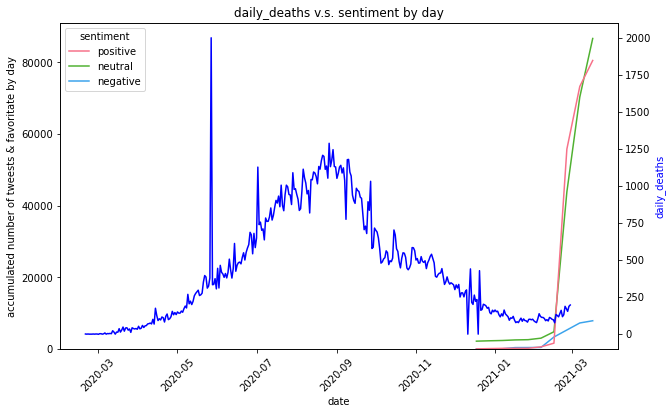

******************************
---------- Spain ----------


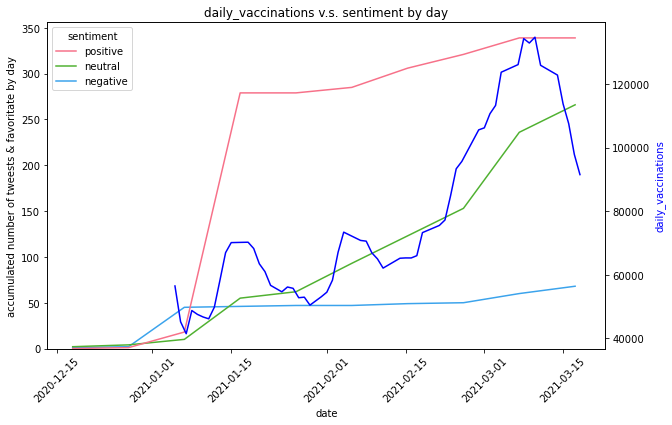

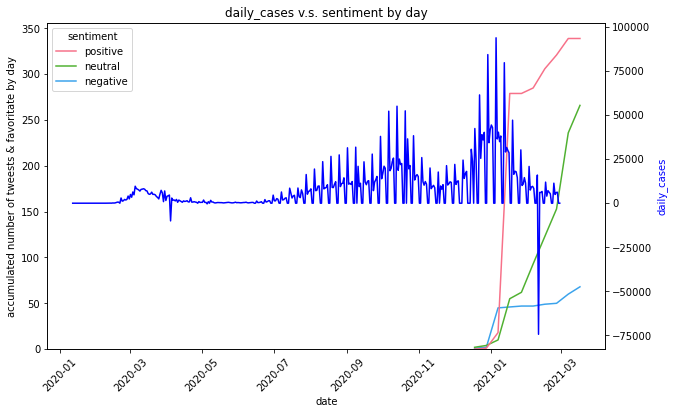

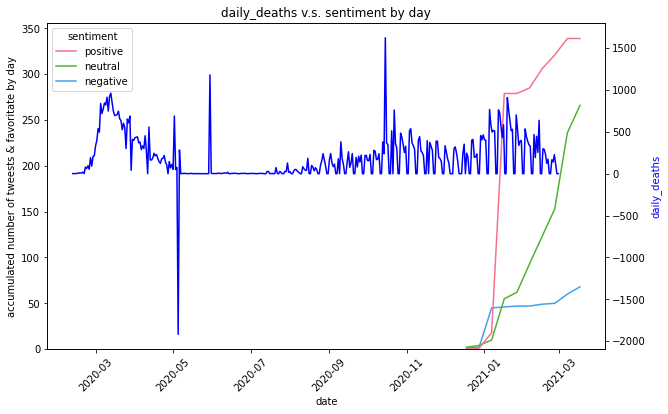

******************************
---------- Chile ----------


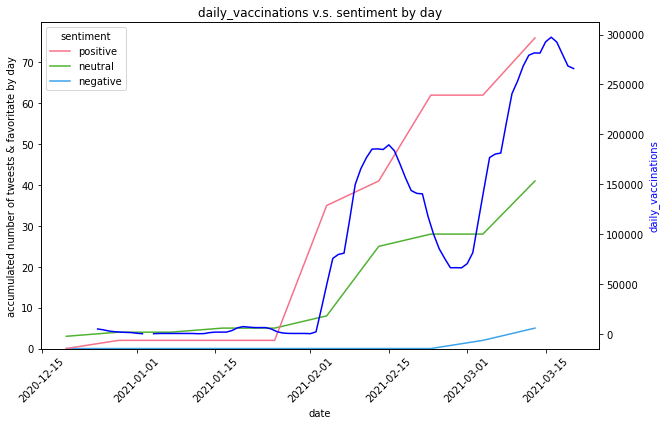

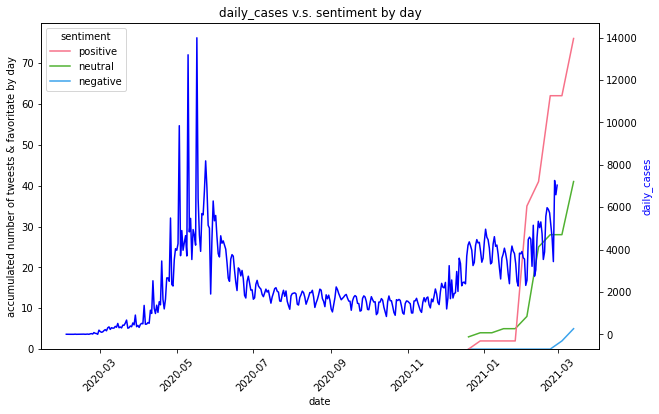

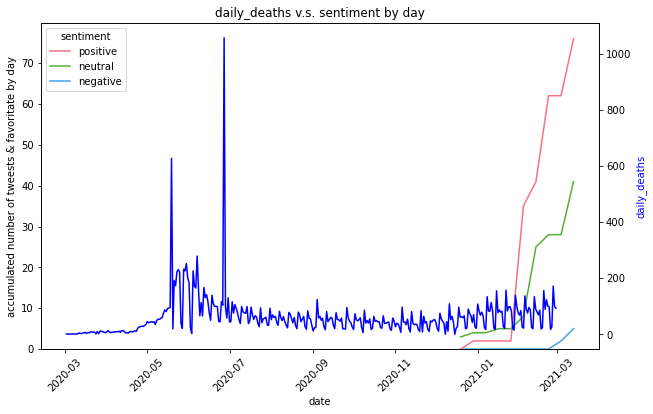

******************************
---------- Bangladesh ----------


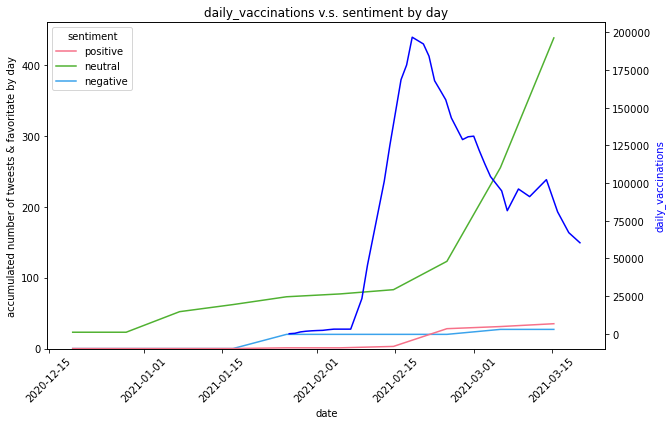

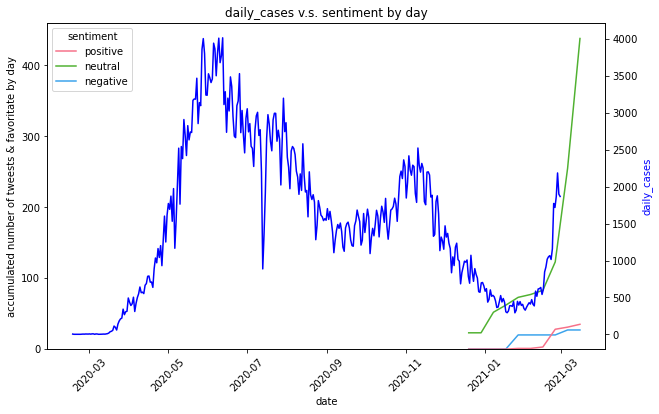

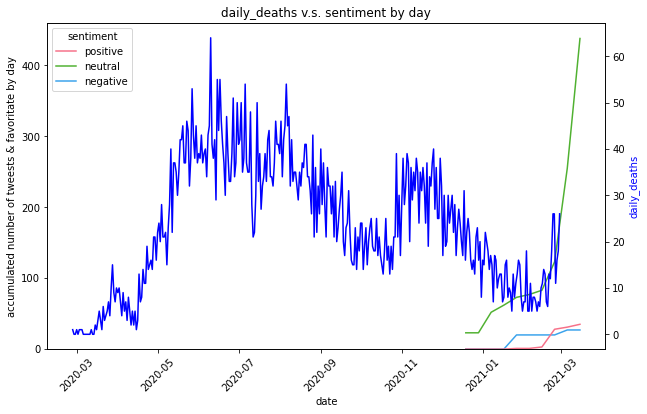

******************************
---------- Italy ----------


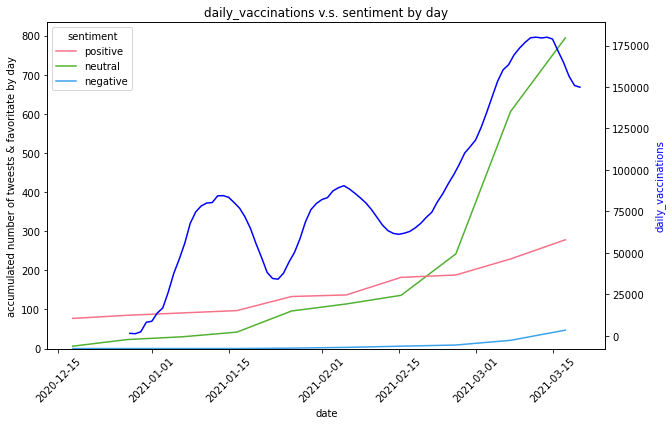

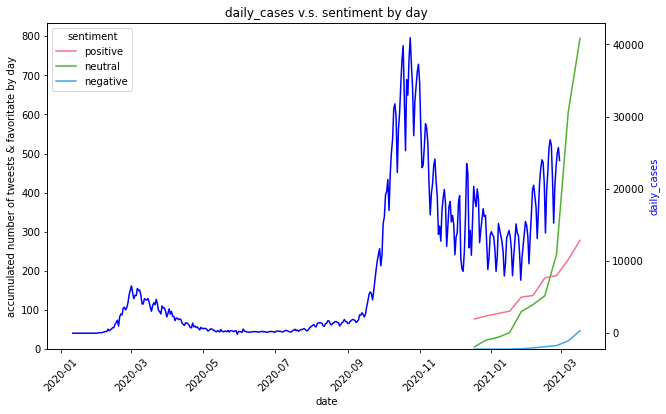

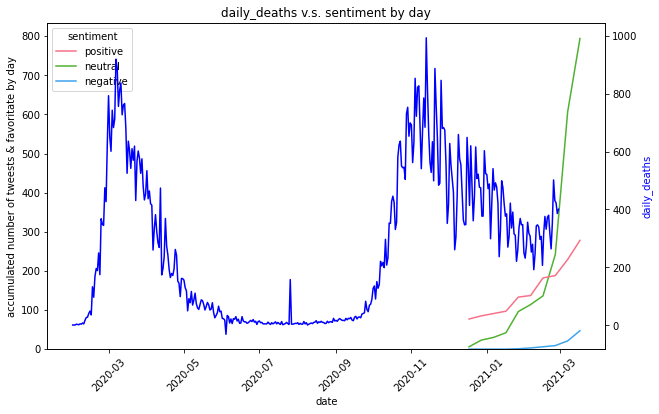

******************************
---------- Turkey ----------


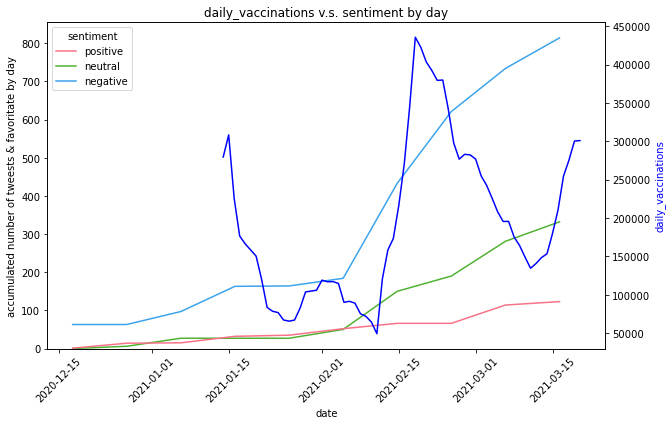

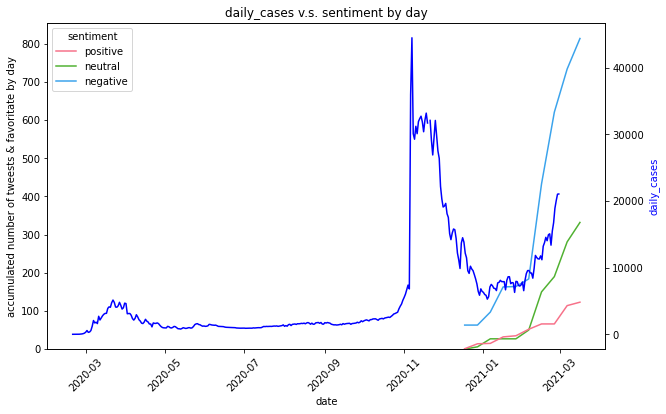

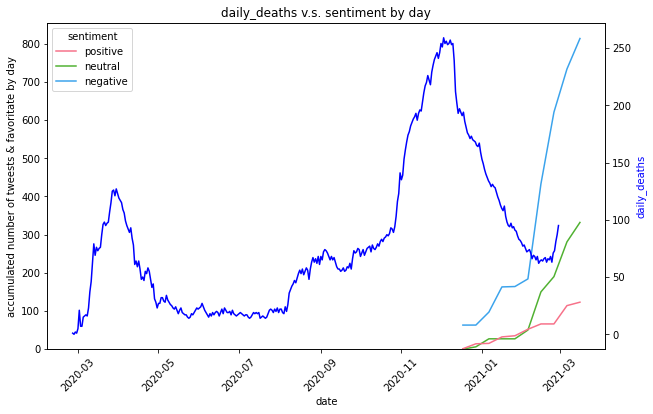

******************************
---------- Russia ----------


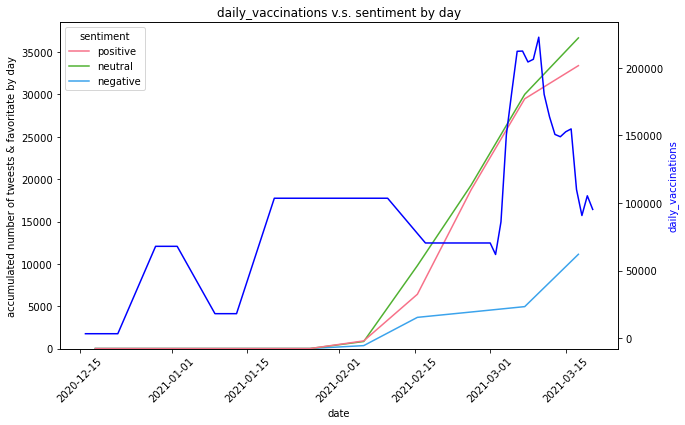

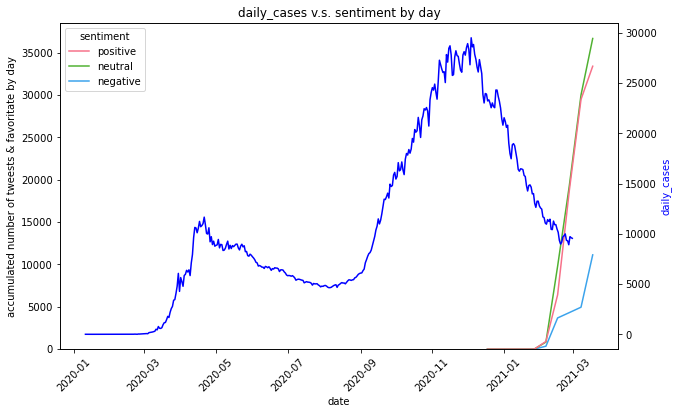

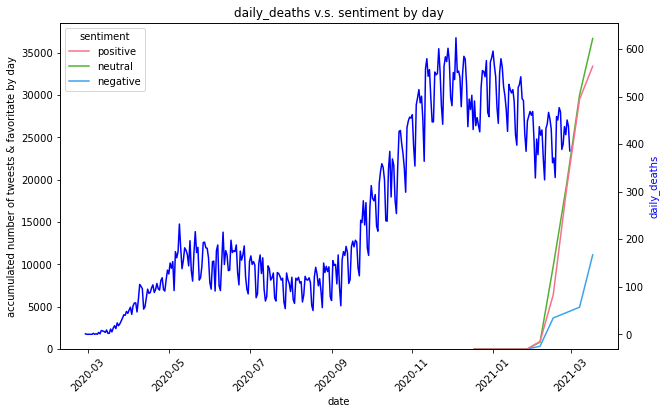

******************************
---------- Brazil ----------


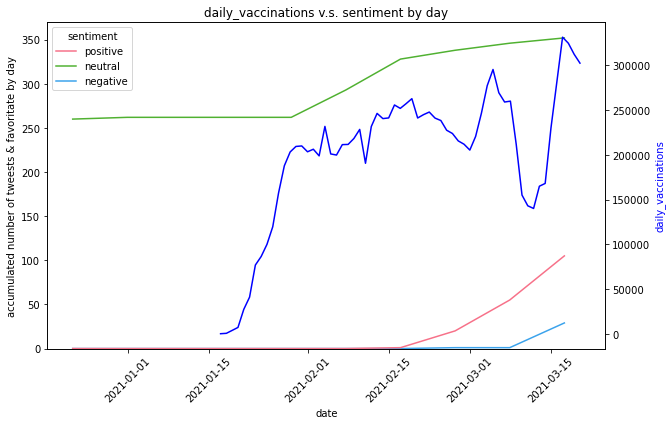

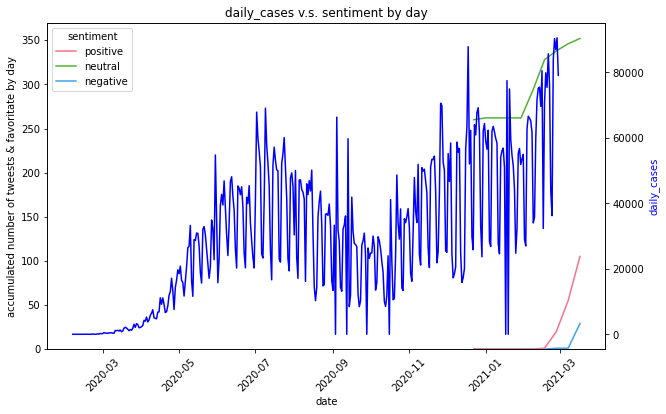

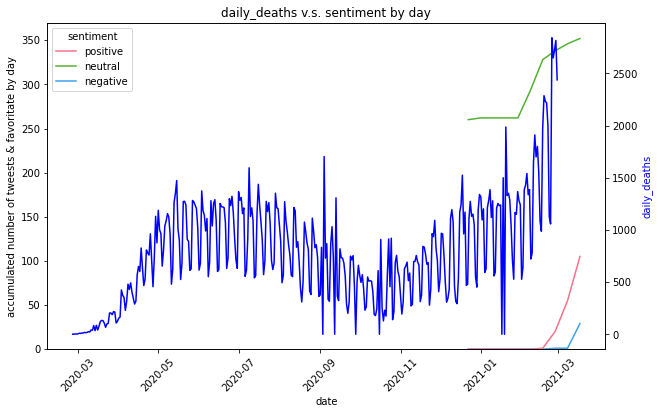

******************************
---------- Poland ----------


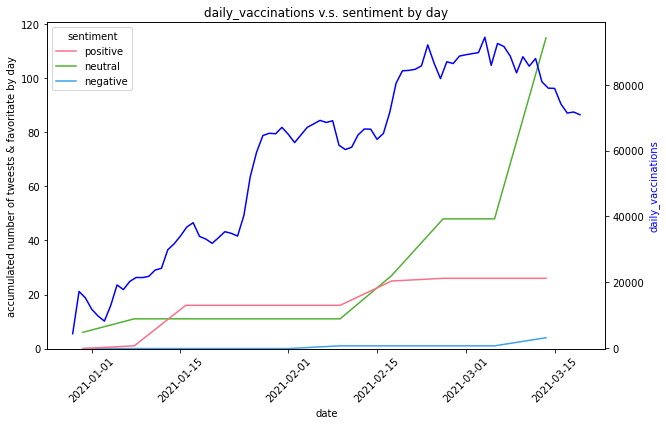

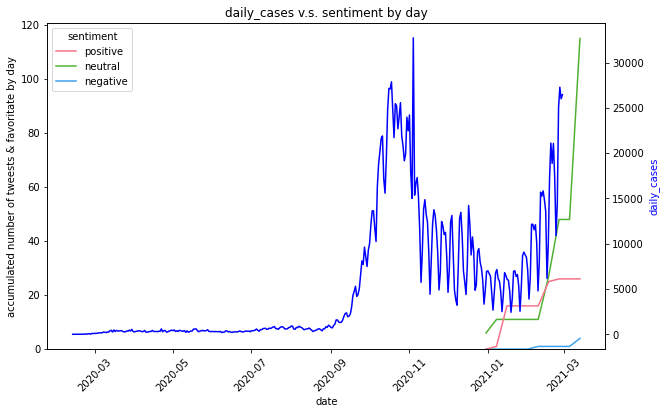

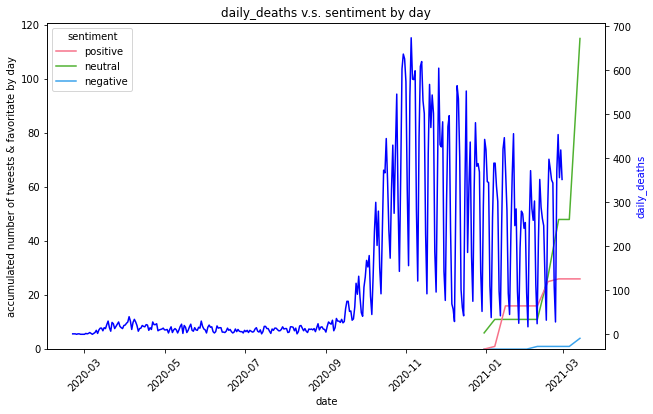

******************************
---------- United Arab Emirates ----------


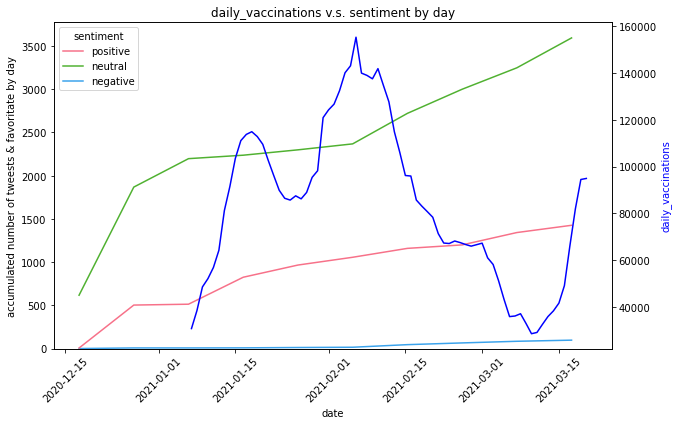

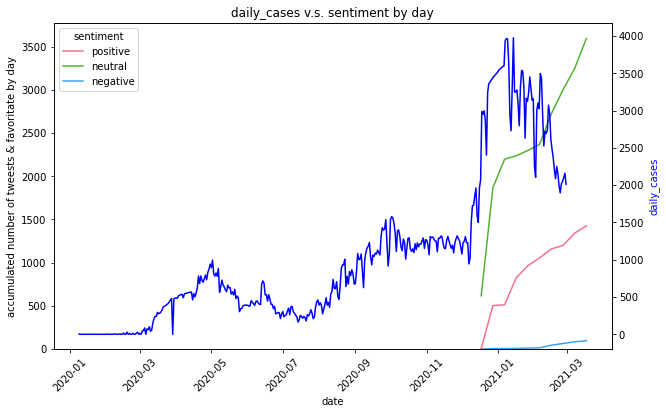

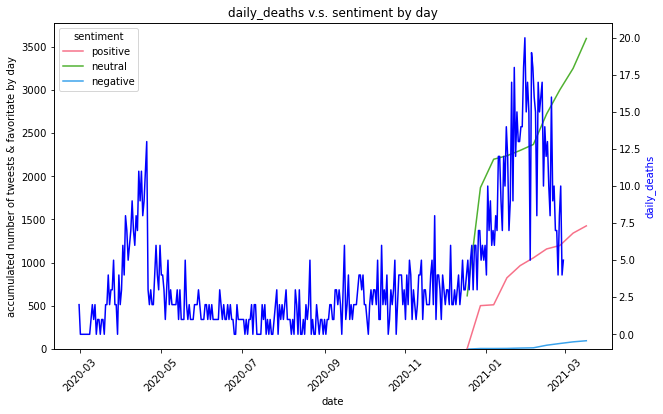

******************************


In [41]:
# plot daily vaccinations v.s. daily cases v.s. daily death v.s. daily tweets (sentiments) for top 20 countries
dataVaccineByCountry = dataVaccine.groupby(by = 'country')
dataCaseByCountry = dataCase.groupby(by = 'country')
dataTweetByCountry = data.groupby(by = 'country')
for country in top20Country:
    print('-' * 10, country, '-' * 10)
    try:
        dv = dataVaccineByCountry.get_group(country)[[
            'daily_vaccinations', 'date']].groupby(by = 'date').agg('max').reset_index()
        dc = dataCaseByCountry.get_group(country)[[
            'daily_cases', 'daily_deaths', 'date']].groupby(by = 'date').agg('max').reset_index()
        dt = dataTweetByCountry.get_group(country)[[
            'number of tweets', 'sentiment', 'date']].groupby(by = 'date').agg({
            'number of tweets': 'sum', 'sentiment': 'first'}).reset_index()
        plotVsTweets(dv, 'daily_vaccinations', dt, 'sentiment', hueOrder)
        plotVsTweets(dc, 'daily_cases', dt, 'sentiment', hueOrder)
        plotVsTweets(dc, 'daily_deaths', dt, 'sentiment', hueOrder)
    except Exception as e:
        print(country, 'not ploted due to error:', e)
    print('*' * 30)

### Thoughts:
* In general, the number of tweets & favorites per day matches the number of vaccinations per day.
* Daily cases and daily deaths seems not to have very strong connection with the number of tweets & favorites per day.
* In Canada, Indonesia, France, Bangladesh, Italy, Brazil, and Poland, there are less positive tweets. These countries have either experience setbacks in vaccination progress or rise in daily COVID cases. A extreme case is Turkey, where there are way more negative tweets & favorites, and sees both setbacks in vaccination and rise in daily COVID cases.
* In others countries, there are more positive tweets & favorites.

## <a id = '5.2'>5.2. Vaccination v.s. COVID cases v.s. tweet topics</a>

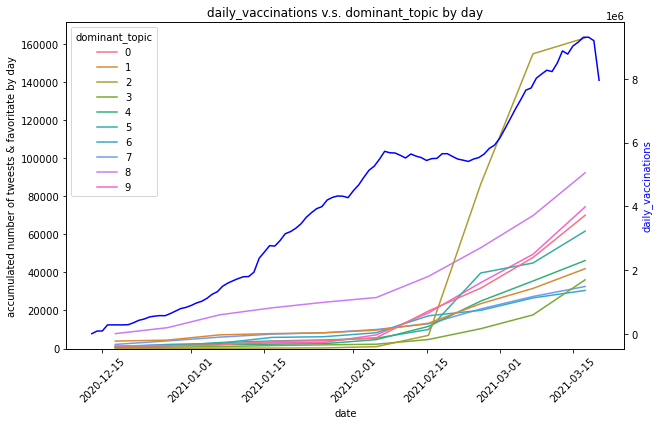

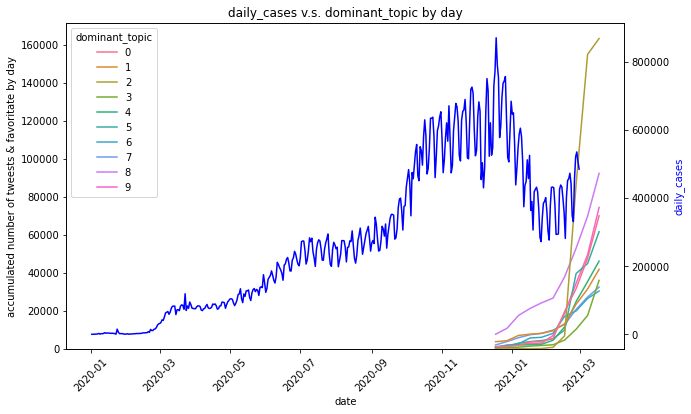

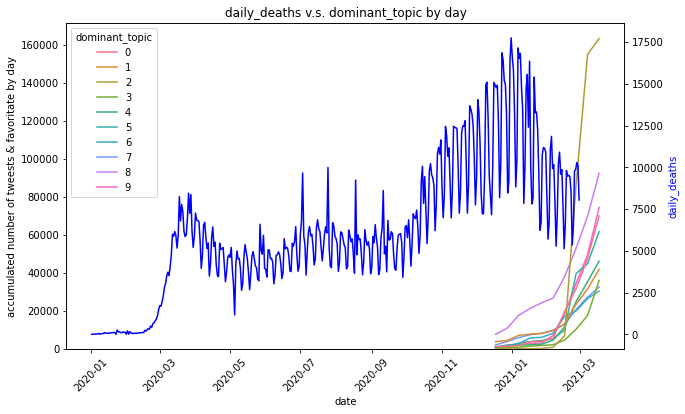

In [42]:
hueOrder = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# plot 'daily_vaccinations' v.s. tweets topics by day
plotVsTweets(dataVaccineByDay, 'daily_vaccinations', dataTopicByDay, 'dominant_topic', hueOrder)
# plot 'daily_cases' v.s. tweets topics by day
plotVsTweets(dataCaseByDay, 'daily_cases', dataTopicByDay, 'dominant_topic', hueOrder)
# plot 'daily_deaths' v.s. tweets topics by day
plotVsTweets(dataCaseByDay, 'daily_deaths', dataTopicByDay, 'dominant_topic', hueOrder)

---------- United Kingdom ----------


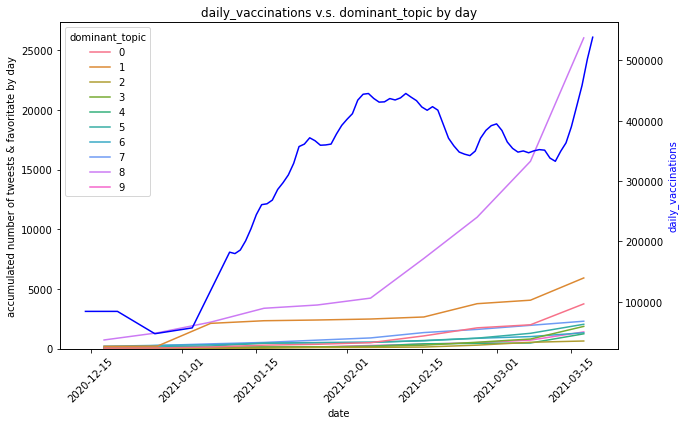

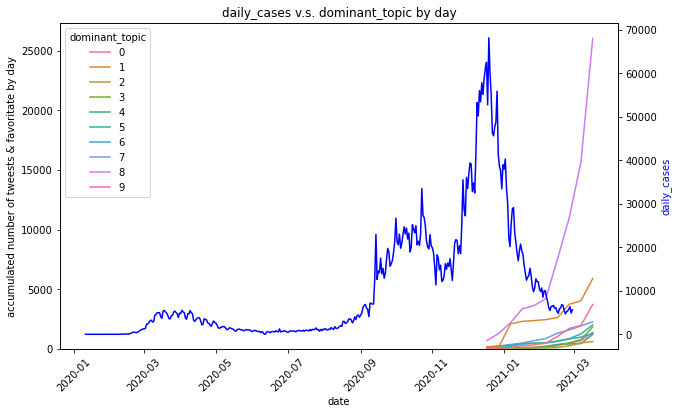

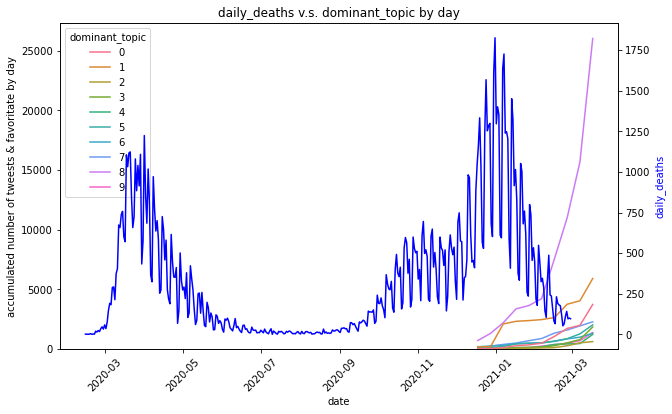

******************************
---------- Morocco ----------


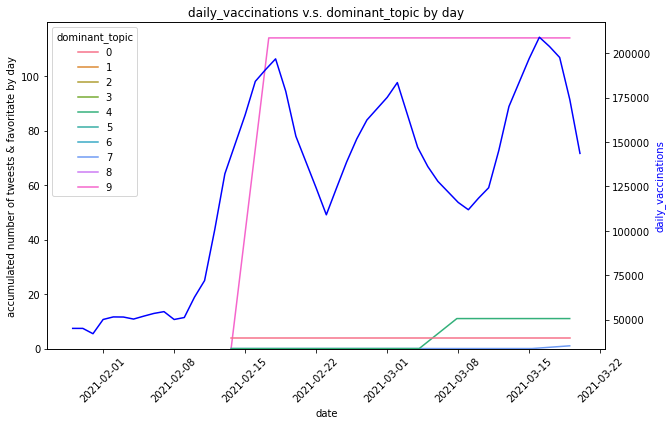

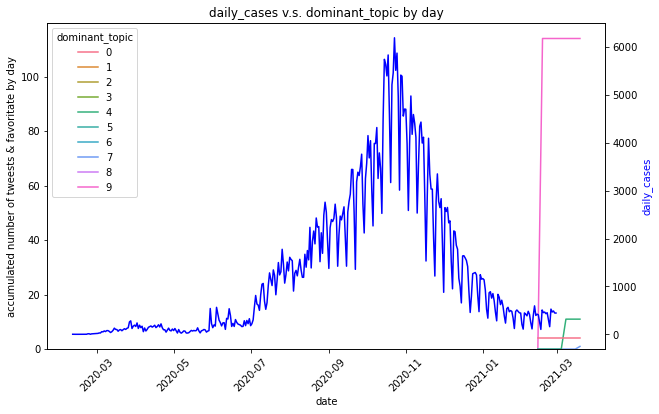

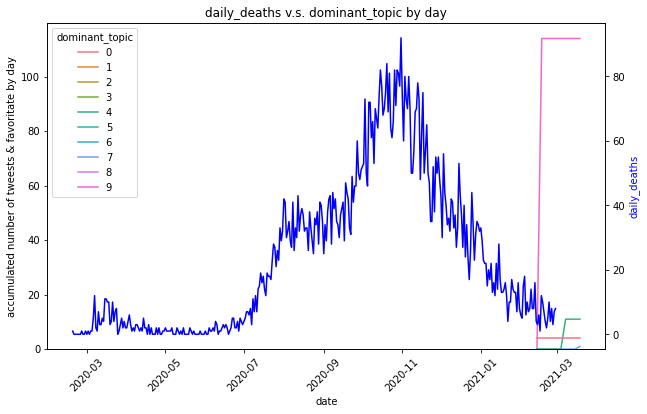

******************************
---------- China ----------


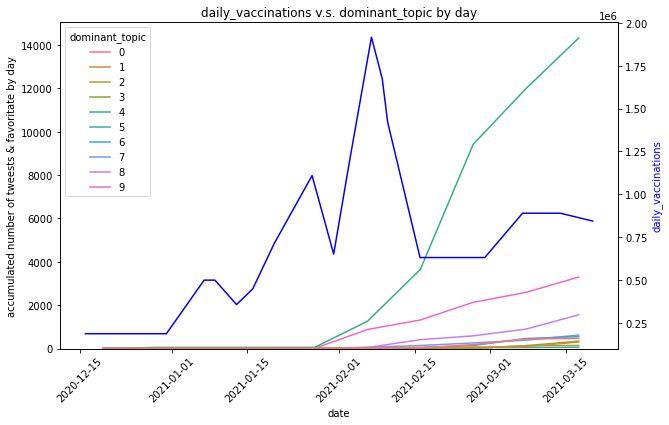

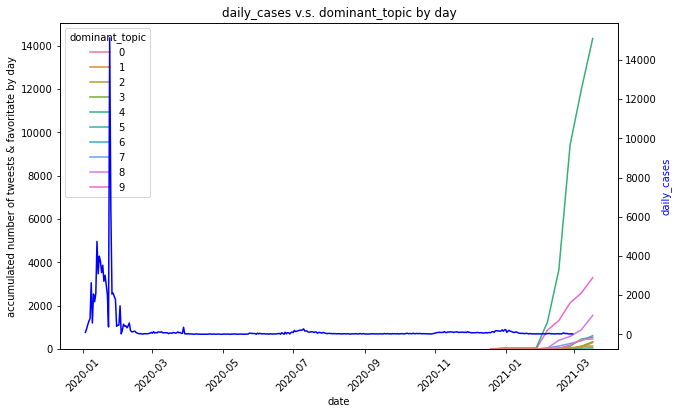

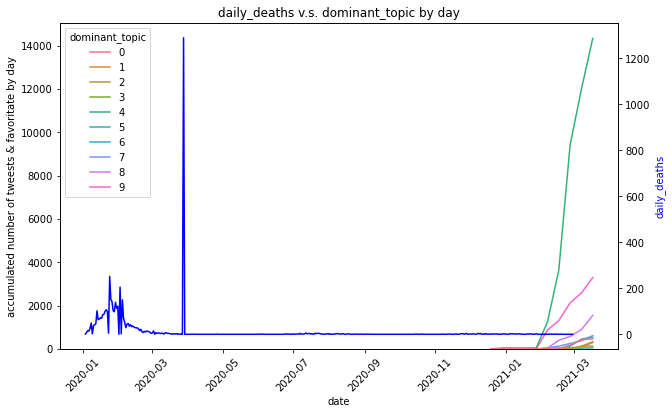

******************************
---------- Germany ----------


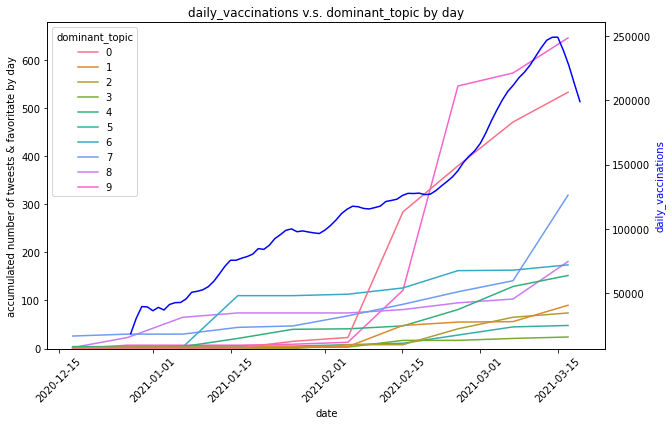

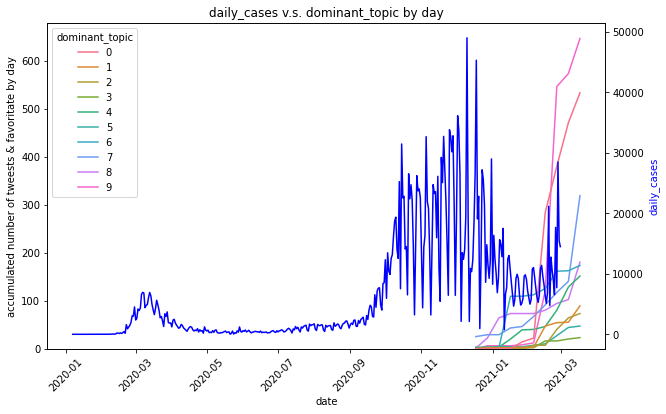

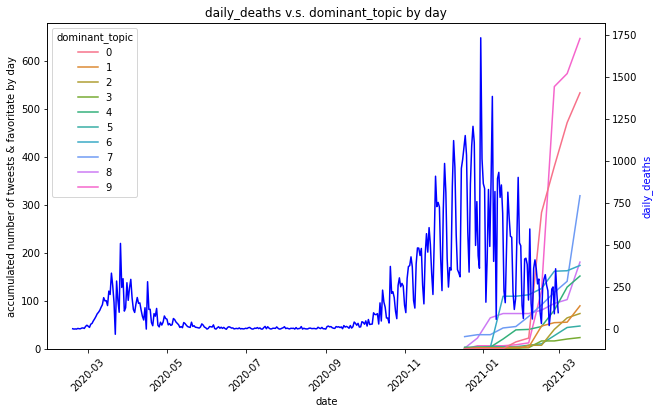

******************************
---------- Indonesia ----------


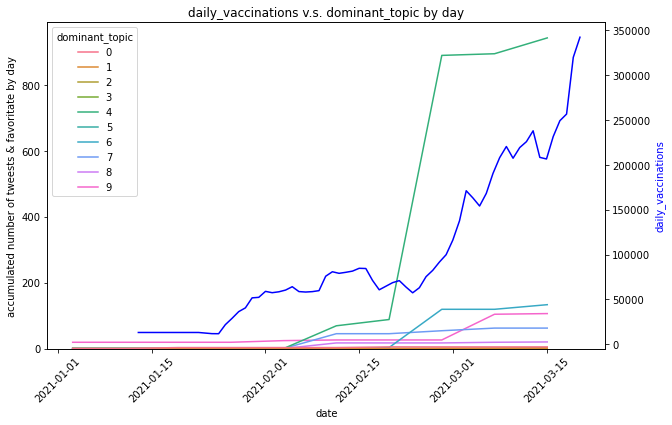

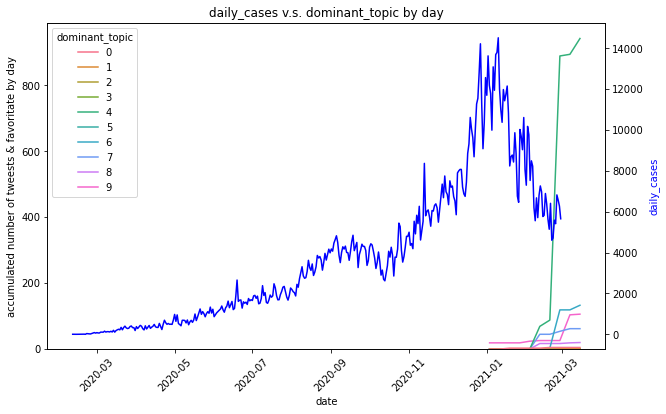

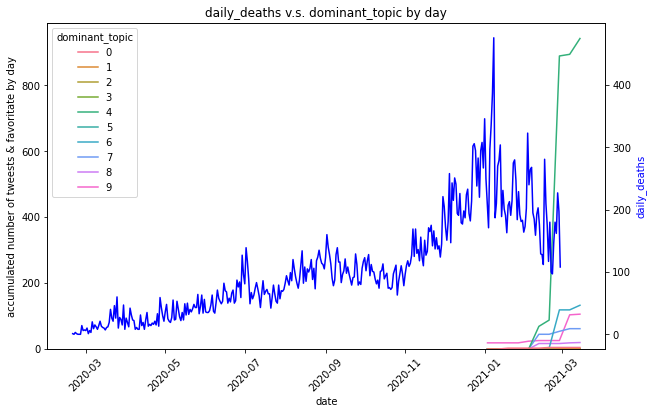

******************************
---------- Canada ----------


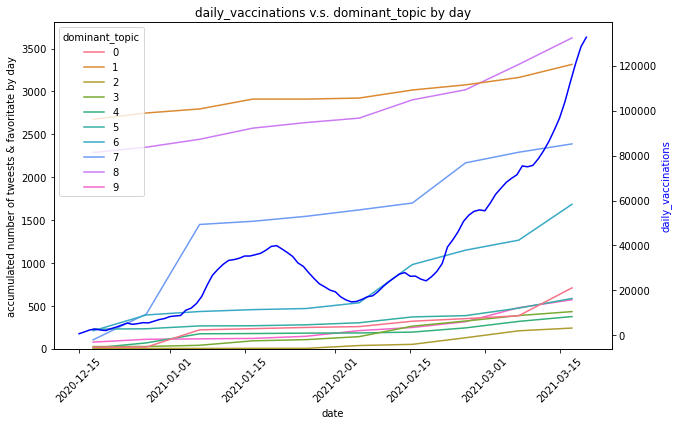

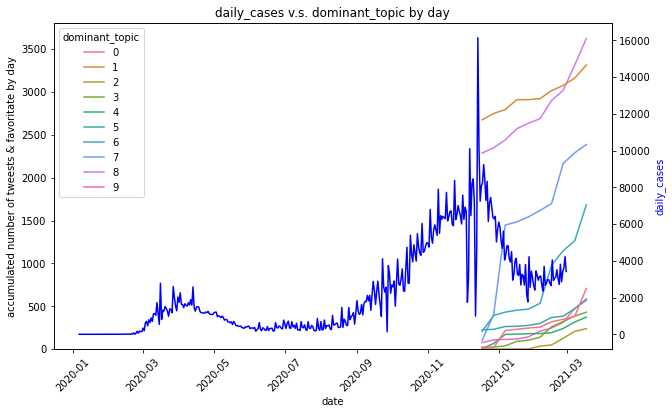

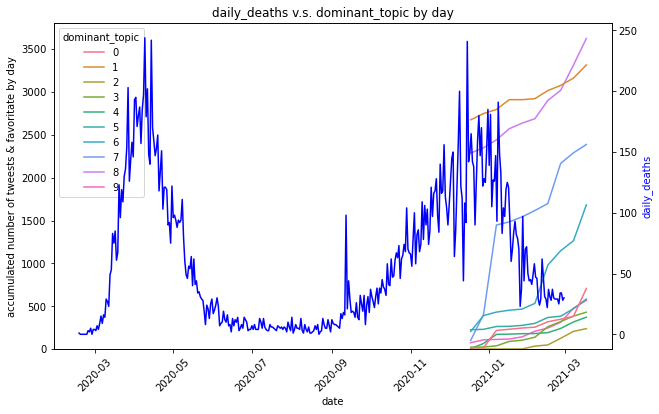

******************************
---------- United States ----------


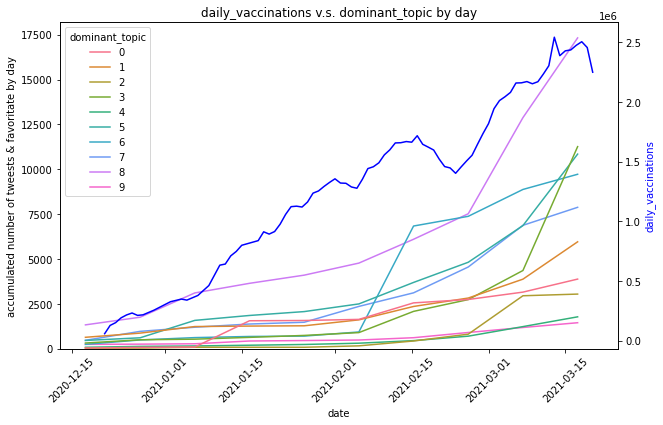

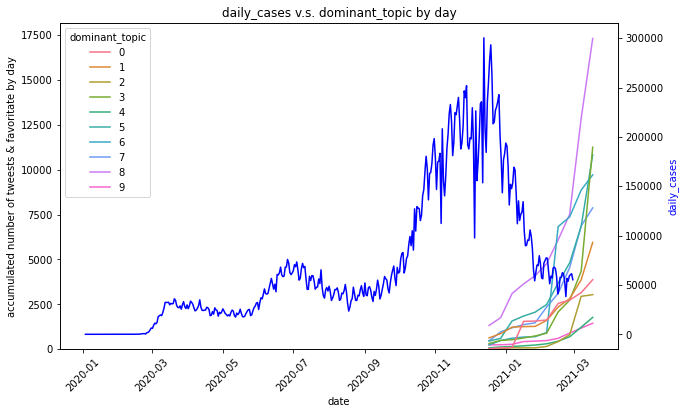

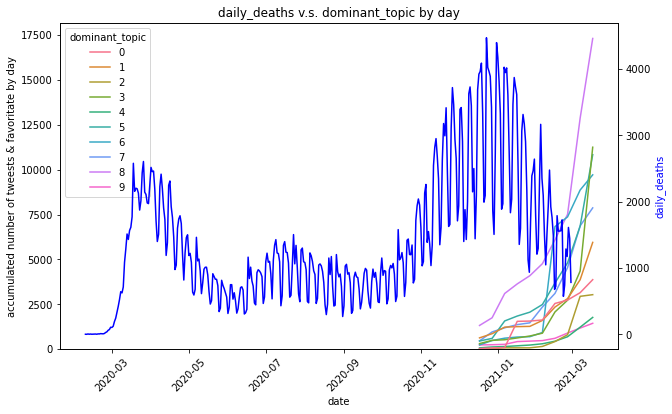

******************************
---------- Mexico ----------


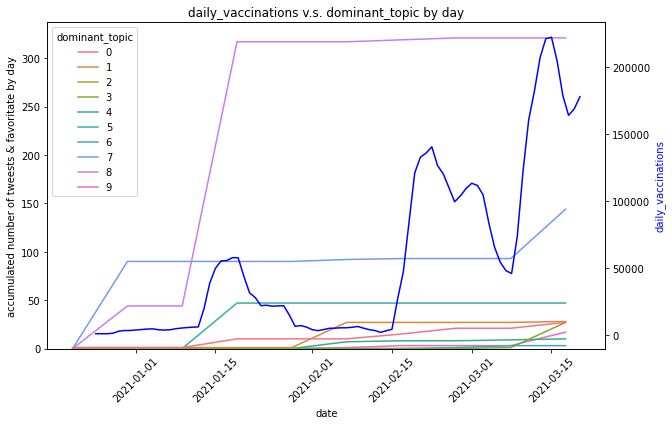

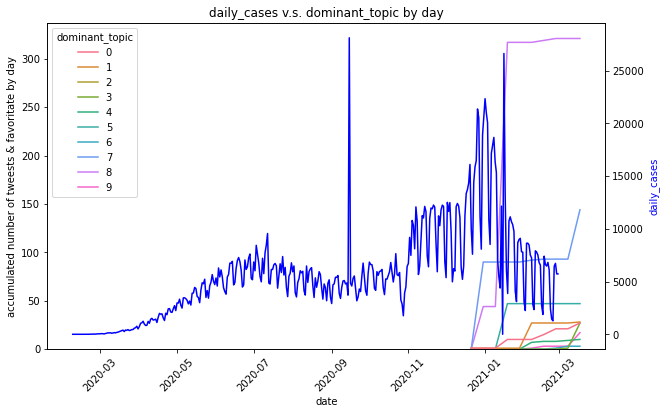

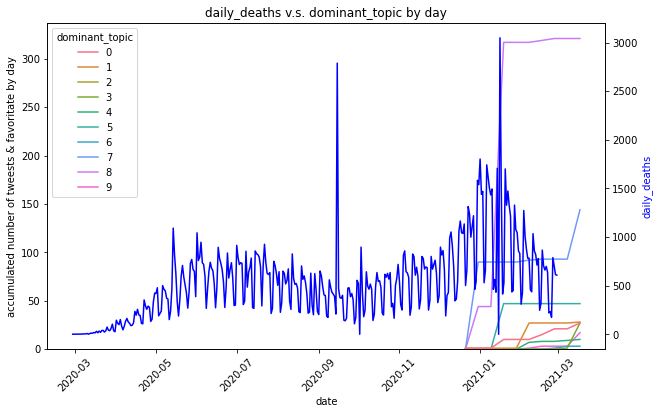

******************************
---------- France ----------


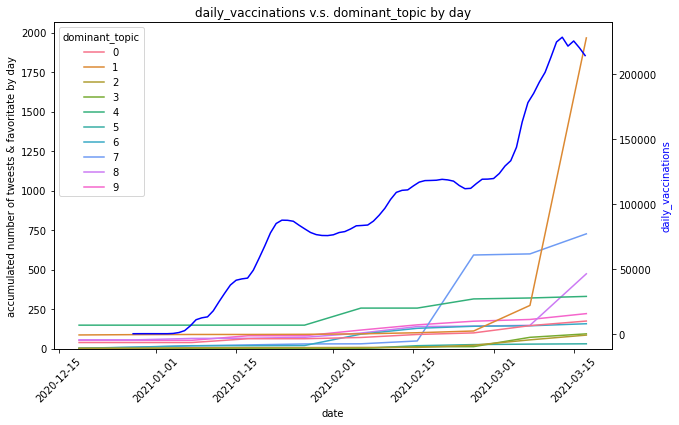

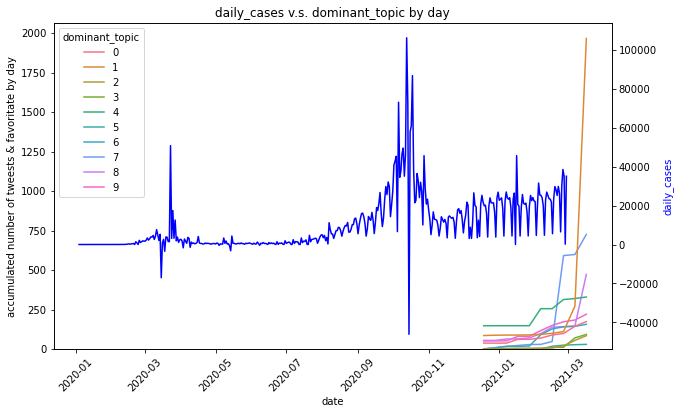

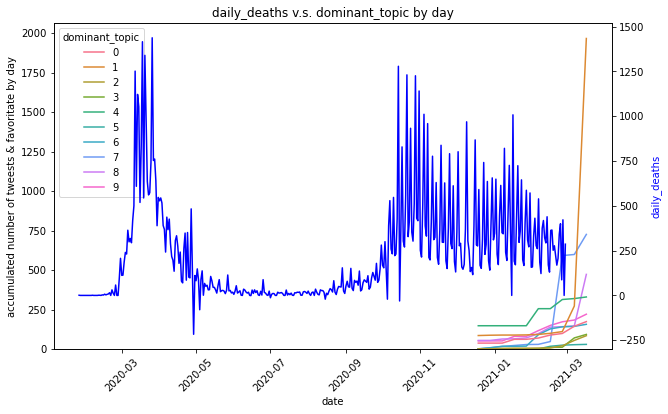

******************************
---------- Israel ----------


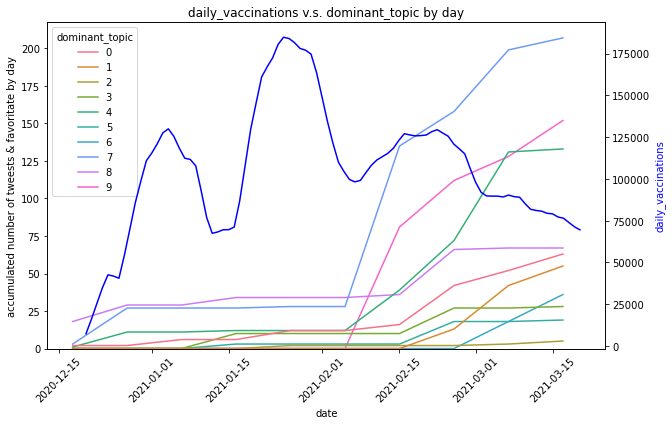

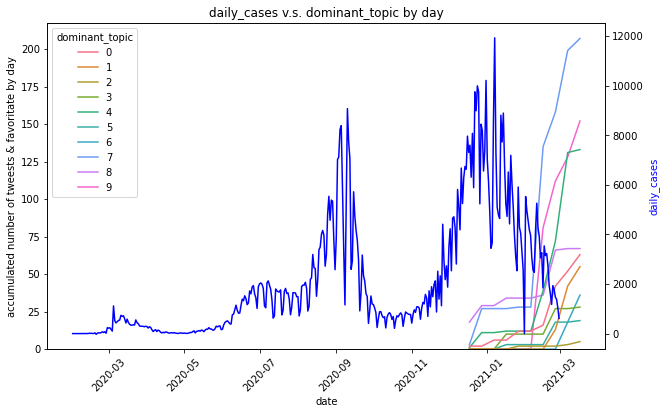

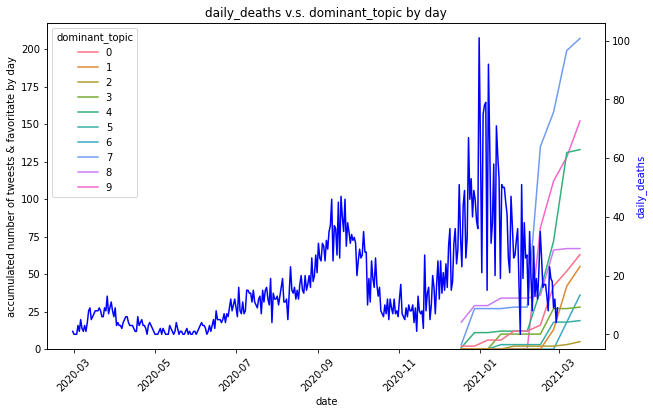

******************************
---------- India ----------


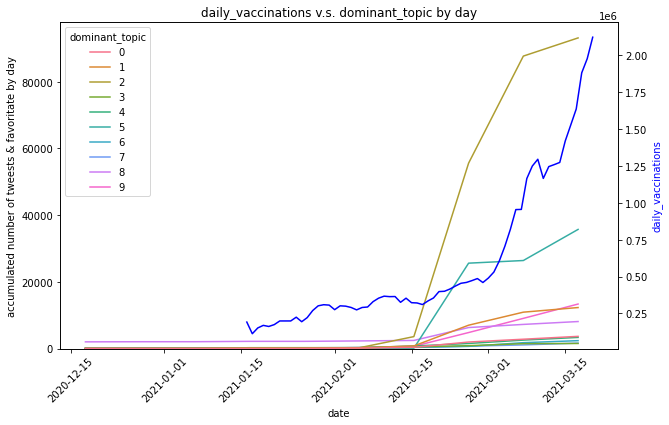

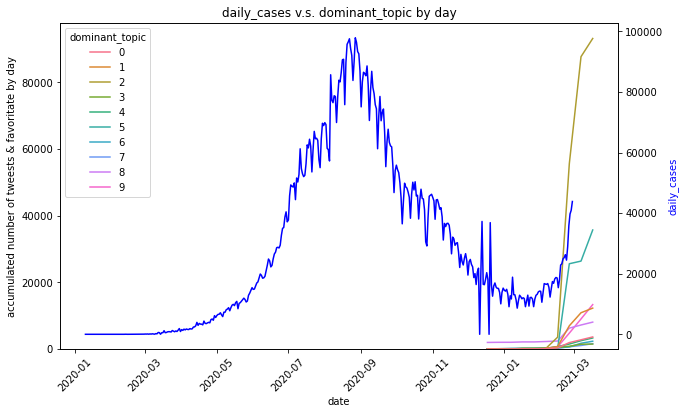

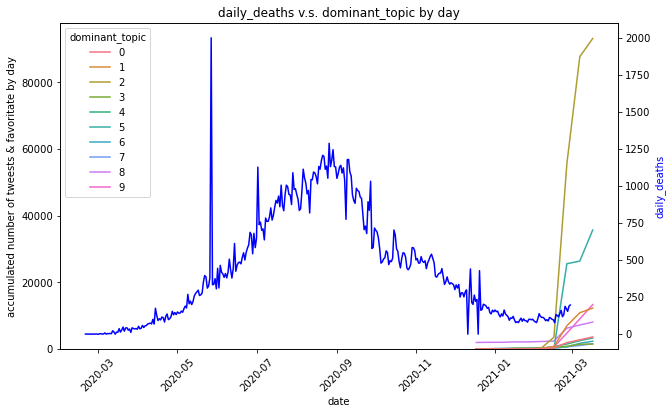

******************************
---------- Spain ----------


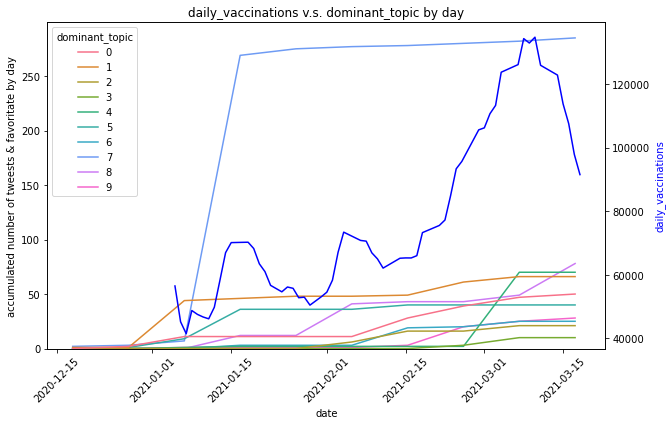

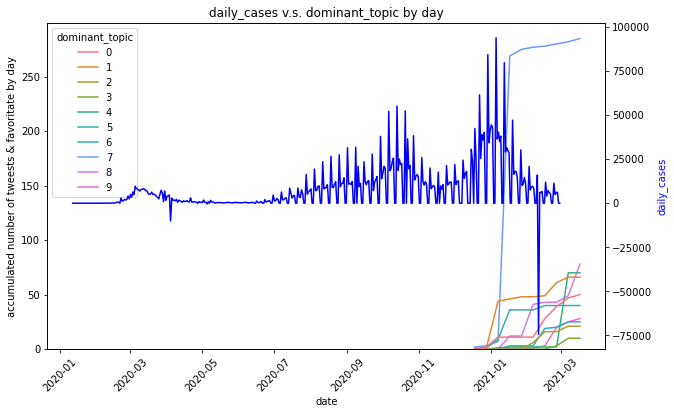

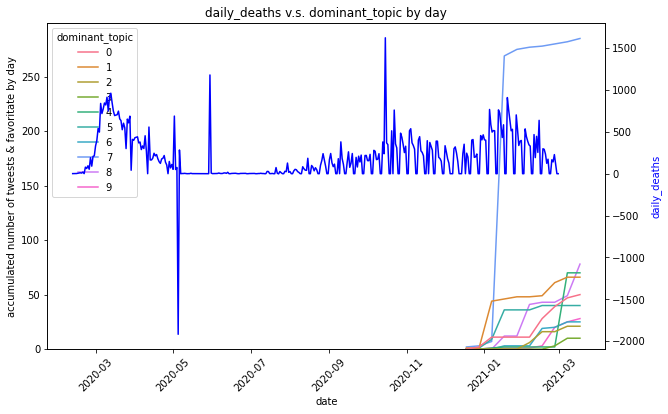

******************************
---------- Chile ----------


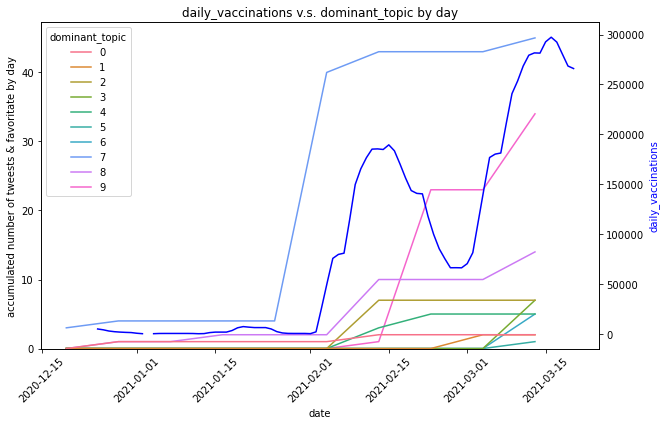

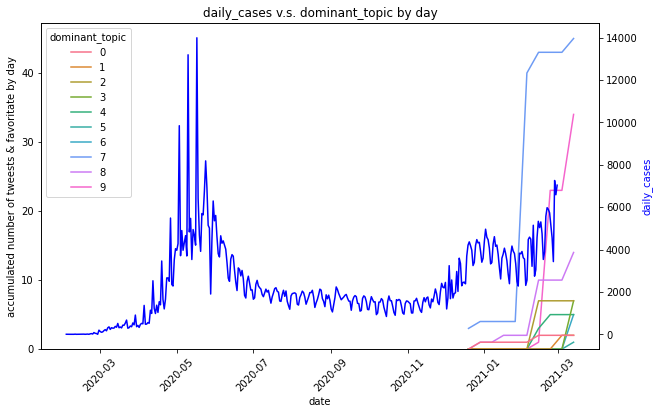

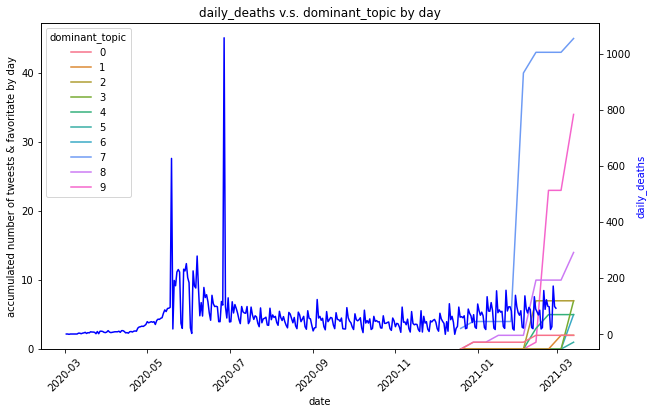

******************************
---------- Bangladesh ----------


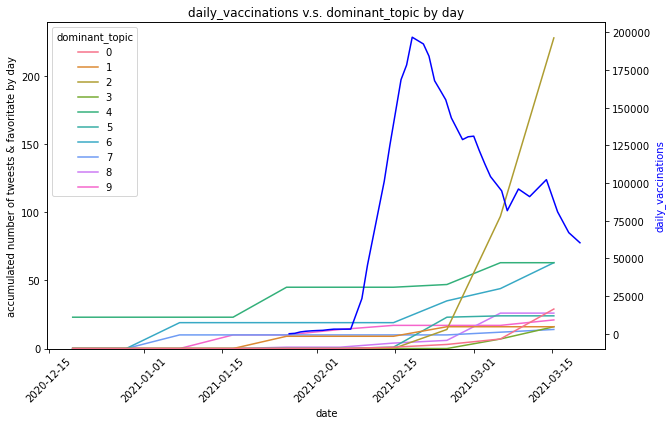

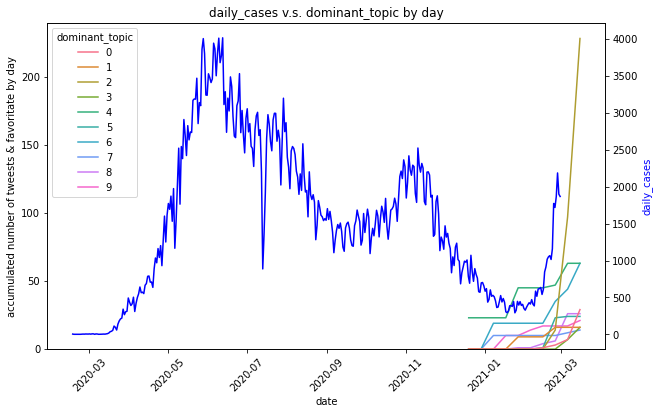

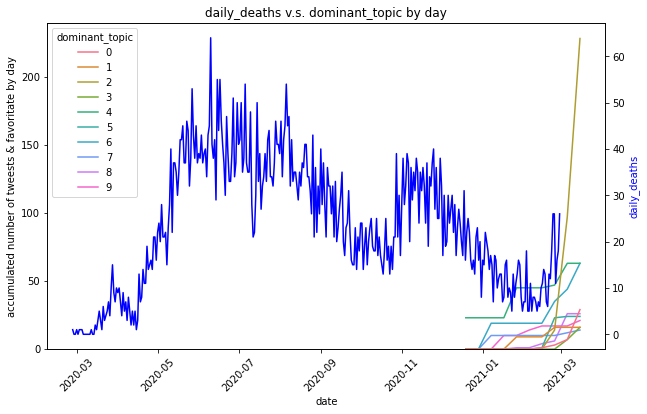

******************************
---------- Italy ----------


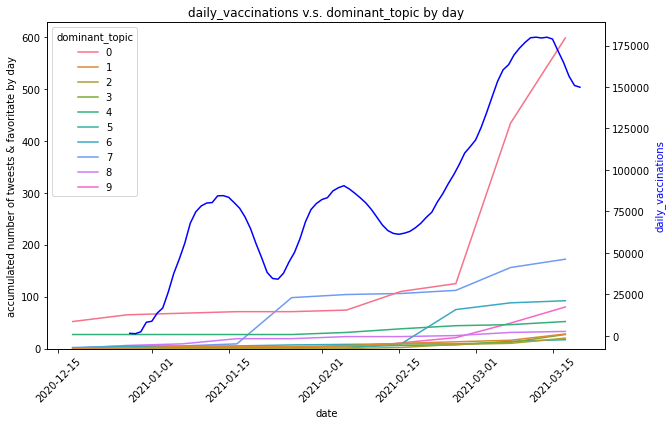

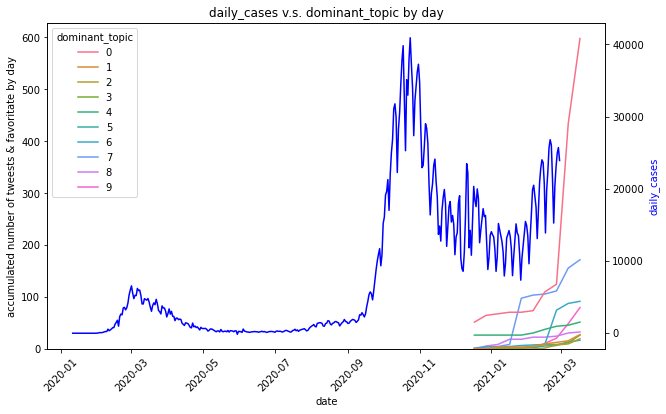

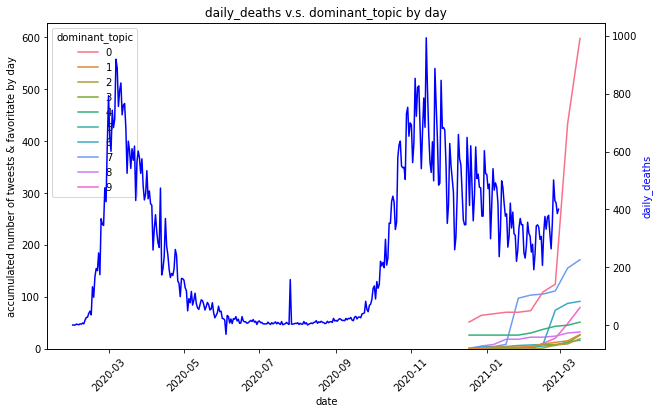

******************************
---------- Turkey ----------


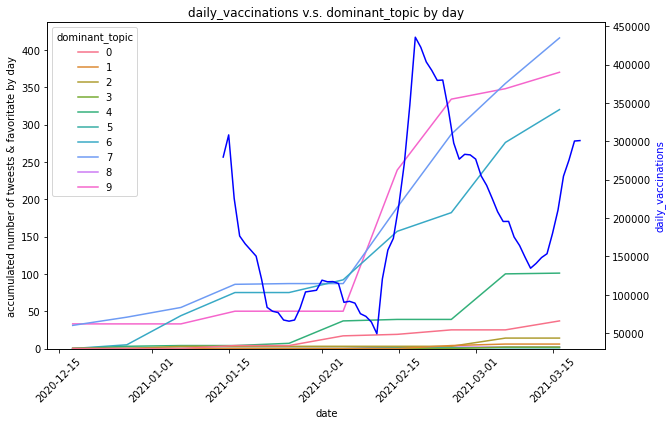

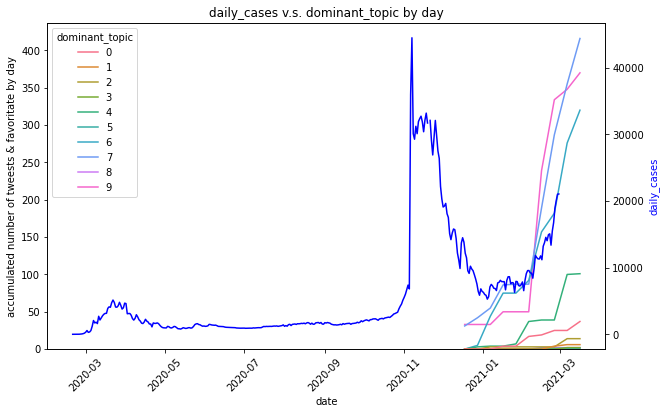

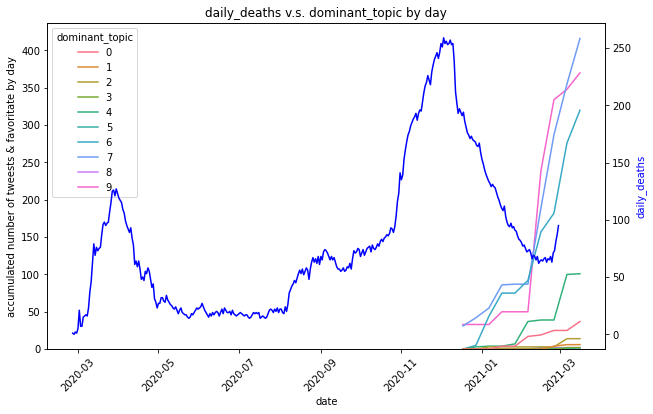

******************************
---------- Russia ----------


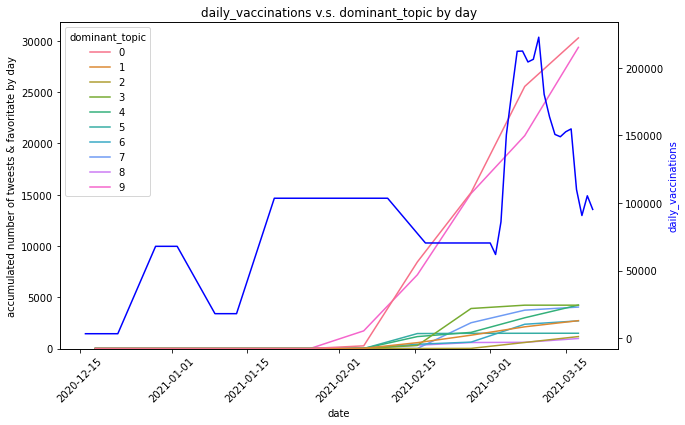

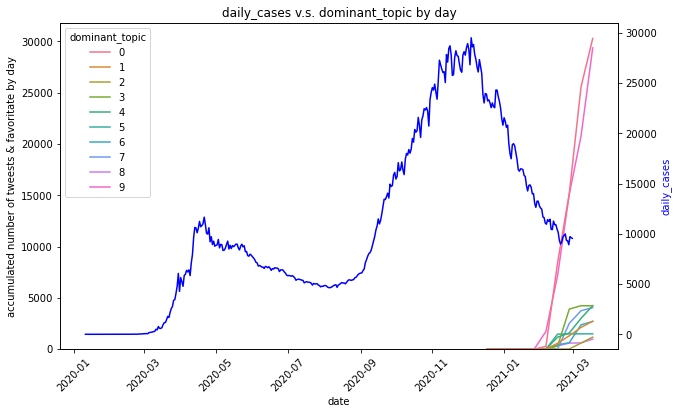

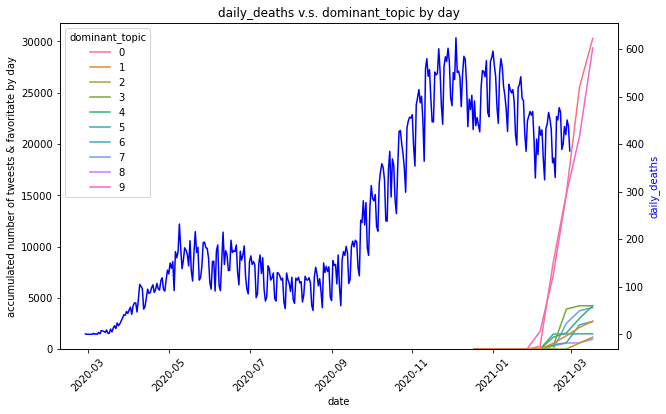

******************************
---------- Brazil ----------


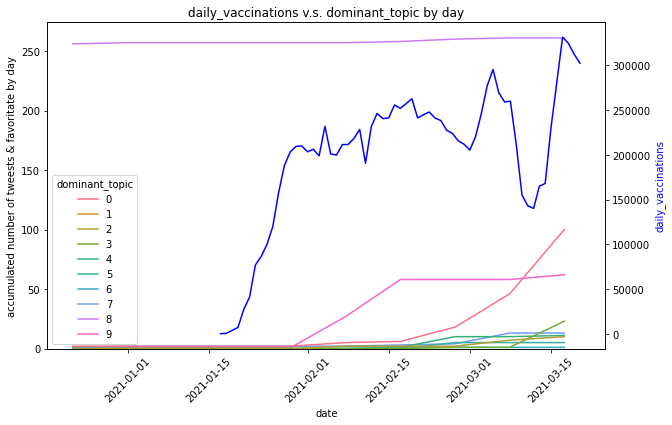

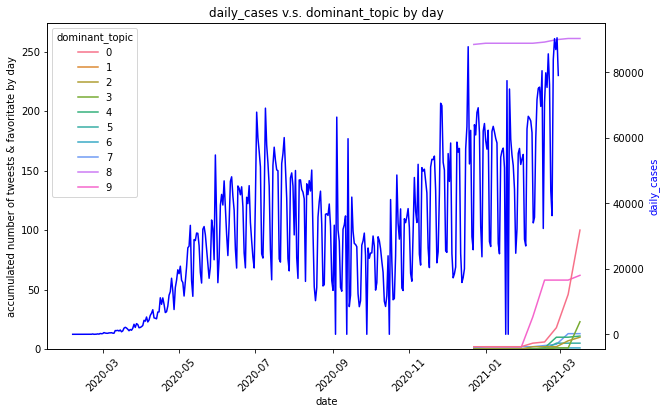

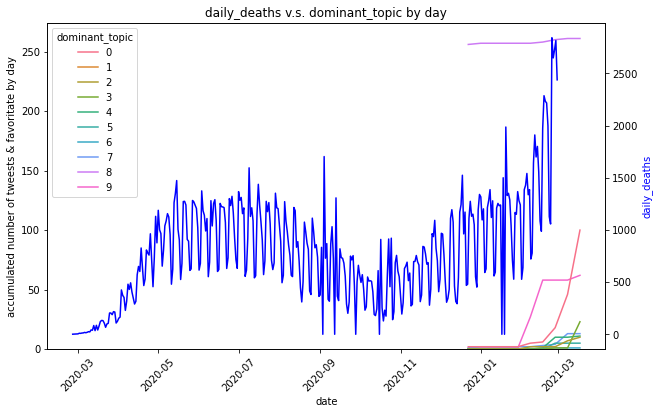

******************************
---------- Poland ----------


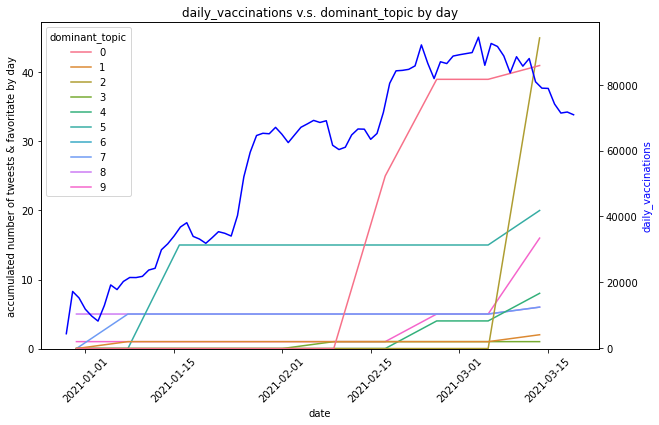

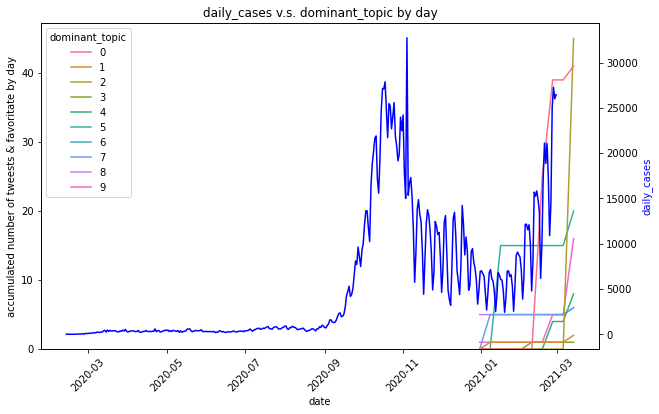

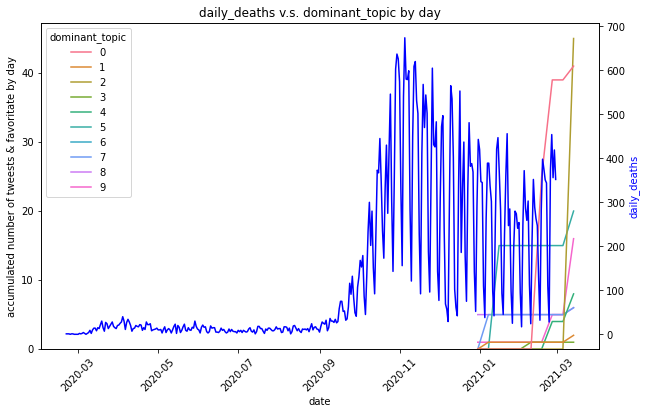

******************************
---------- United Arab Emirates ----------


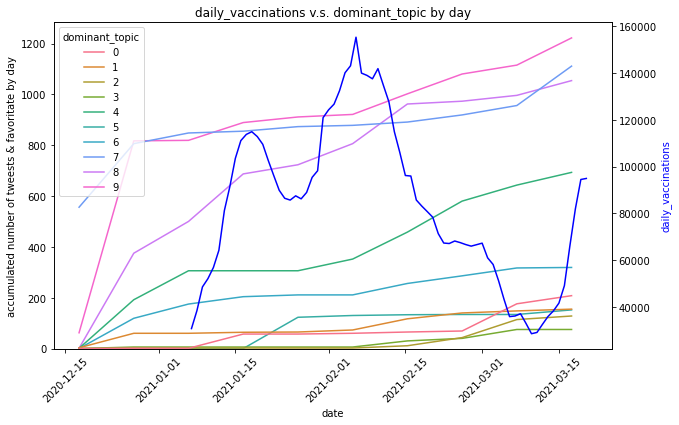

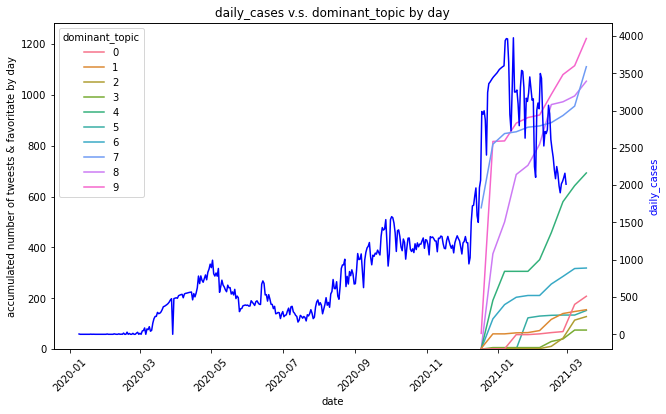

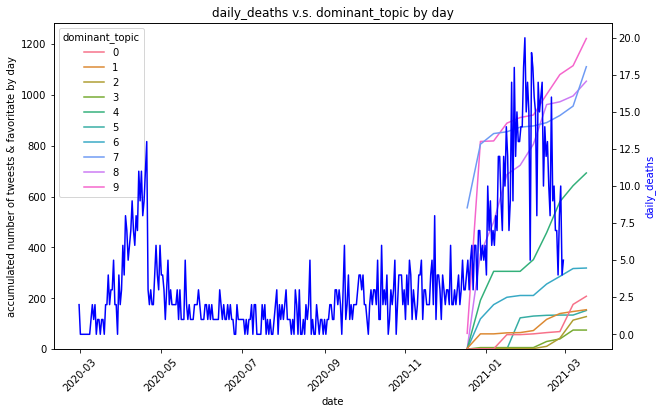

******************************


In [45]:
# plot daily vaccinations v.s. daily cases v.s. daily death v.s. daily tweets (topics) for top 20 countries
for country in top20Country:
    print('-' * 10, country, '-' * 10)
    try:
        dv = dataVaccineByCountry.get_group(country)[[
            'daily_vaccinations', 'date']].groupby(by = 'date').agg('max').reset_index()
        dc = dataCaseByCountry.get_group(country)[[
            'daily_cases', 'daily_deaths', 'date']].groupby(by = 'date').agg('max').reset_index()
        dt = dataTweetByCountry.get_group(country)[[
            'number of tweets', 'dominant_topic', 'date']].groupby(by = 'date').agg({
            'number of tweets': 'sum', 'dominant_topic': 'first'}).reset_index()
        plotVsTweets(dv, 'daily_vaccinations', dt, 'dominant_topic', hueOrder)
        plotVsTweets(dc, 'daily_cases', dt, 'dominant_topic', hueOrder)
        plotVsTweets(dc, 'daily_deaths', dt, 'dominant_topic', hueOrder)
    except Exception as e:
        print(country, 'not ploted due to error:', e)
    print('*' * 30)

### Thoughts:
* In most countries, people tweets more about the topic regarding the vaccines used in their country.
* In Morocco, Germany, Italy, Turkey, Russia, Poland and UAE, more tweets & favorites have been posted with respect to the topics on effectiveness of vaccines agains COVID.